This notebook makes projections for GECCO and other MeV gamma-ray telescopes.

## Setup and utils

In [1]:
%load_ext autoreload
%autoreload 2

from math import pi
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np
import jupyter_beeper
from tqdm.auto import tqdm, trange
from collections import defaultdict
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from matplotlib.ticker import LogLocator, NullFormatter

from hazma.parameters import (
    sv_inv_MeV_to_cm3_per_s,
    muon_mass as m_mu,
    charged_pion_mass as m_pi,
    neutral_pion_mass as m_pi0,
    electron_mass as m_e
)
from hazma.gamma_ray_parameters import *
from hazma.theory import TheoryDec, TheoryAnn
from hazma.scalar_mediator import HiggsPortal, HeavyQuark
from hazma.vector_mediator import KineticMixing, QuarksOnly
from hazma.single_channel import SingleChannelAnn, SingleChannelDec

beeper = jupyter_beeper.Beeper()

def beep():
    return beeper.beep(frequency=900, secs=0.7, blocking=True)

AttributeError: module 'numpy.typing' has no attribute 'NDArray'

In [19]:
integral_diffuse_target

TargetParams(J=2.086e+29, D=7.301e+25, dOmega=5.421e-01, vx=1.000e-03)

In [20]:
gc_targets_optimistic["ein"]["1 arcmin cone"]

TargetParams(J=5.987e+34, D=4.179e+27, dOmega=2.660e-07, vx=1.000e-03)

In [21]:
# Other constants
T_obs_nt = 1e6  # s
v_mw = 1e-3
v_m31 = 1e-3
v_draco = 3e-5
x_kd = 1e-6  # DM mass divided by T_kd

# This is approximately the same as `gc_bg_model`, but does not constrain
# the input energies.
gc_bg_model_approx = BackgroundModel(
    [0, 1e5], lambda e: 7 * default_bg_model.dPhi_dEdOmega(e)
)

# Best selection of targets for annihilating and decaying DM
nt_targets_ann = {
    "gc_ein_1_arcmin_cone_optimistic": (
#         gc_targets_optimistic["ein"]["1 arcmin cone"], gc_bg_model_approx
        integral_diffuse_target, gc_bg_model_approx  # TODO: REMOVE!
    ),
#     "gc_nfw_1_arcmin_cone": (gc_targets["nfw"]["1 arcmin cone"], gc_bg_model_approx),
}
nt_targets_dec = {
    "gc_ein_5_deg_optimistic": (
        gc_targets_optimistic["ein"]["5 deg cone"], gc_bg_model_approx
    ),
#     "gc_nfw_5_deg": (gc_targets["nfw"]["5 deg cone"], gc_bg_model_approx),
}


def set_m_med(model, m_med):
    """
    Helper to set mediator mass for different models
    """
    if hasattr(model, "ms"):
        model.ms = m_med
    elif hasattr(model, "mv"):
        model.mv = m_med
    else:
        raise AttributeError("could not determine mediator name")

In [ ]:
def get_constraints(
    model,
    mxs,
    m_meds=None,
    existing=["comptel", "egret", "fermi", "integral"],
    new=["adept", "amego", "e_astrogam", "grams", "pangu", "mast"],
    cmb=True
):
    """
    Compute indirect detection constraints for existing and new telescopes
    and CMB.
    """
    if issubclass(type(model), TheoryAnn):
        nt_targets = nt_targets_ann
    elif issubclass(type(model), TheoryDec):
        nt_targets = nt_targets_dec
    else:
        raise ValueError("invalid model type")

    constraints = defaultdict(lambda: np.zeros(len(mxs)))
    
    for i in trange(len(mxs)):
        model.mx = mxs[i]
        if m_meds is not None:
            set_m_med(model, m_meds[i])

        # Constraints from existing data
        for telescope in existing:
            constraints[telescope][i] = model.binned_limit(
                eval(f"{telescope}_diffuse"), method="1bin"
            )

        # Projections
        for nt in new:
            for key, (target, bg_model) in nt_targets.items():
                constraints[nt + "_" + key][i] = model.unbinned_limit(
                    eval(f"A_eff_{nt}"),
                    eval(f"energy_res_{nt}"),
                    T_obs_nt,
                    target,
                    bg_model,
                )

        # TODO: what x_kd value should be used for decaying DM?
        if cmb:
            # Constraint on <sigma v> in CMB era
            constraints["cmb"][i] = model.cmb_limit(x_kd=x_kd)

    return dict(constraints)

def plot_existing(ax, mxs, svs, label, color, y2=1):
    """
    Plot existing constraints in a consistent manner
    """
    if label == r"CMB ($s$-wave)":
        ax.plot(mxs, svs, "-.k", linewidth=1, label=label)
    elif label == r"CMB ($p$-wave)":
        v_cmbs = 2e-4 * (0.235) * (1 / mxs) * np.sqrt(1e-4 / x_kd)
        ax.plot(
            mxs, svs * (v_mw / v_cmbs)**2, "--k", linewidth=1, label=label
        )
    else:
        ax.fill_between(mxs, svs, y2=y2, label=label, alpha=0.3, color=color)
        ax.loglog(mxs, svs, "-", color=color, linewidth=0.5)


def contourf(
    ax, x, y, z, label=None, color=None, alpha=0.3, hatch=None,
    linestyle=None, levels=[-np.inf, 0]
):
    """
    contourf helper with proxy artists for the legend
    """
    cs = ax.contourf(
        x, y, z, levels=levels, alpha=alpha, colors=color, hatches=[hatch],
        linestyles=[linestyle]
    )

    # Fix hatching, add proxies for legend
    for col in cs.collections:
        col.set_edgecolor(color)
        # Make the proxy artist invisible so it doesn't mess up the layout
        ax.patches.append(
            plt.Rectangle(
                (0, 0), 0, 0,
                color=color,
                hatch=col.get_hatch(),
                alpha=alpha,
                label=label,
                linestyle=linestyle
            )
        )
    
    return cs

In [ ]:
# Base figure size
fig_dim = 4

mpl_colors = [c["color"] for c in plt.rcParams["axes.prop_cycle"]]
# Colorblind palette (https://gist.github.com/thriveth/8560036)
# mpl_colors = [
#     '#377eb8', '#ff7f00', '#4daf4a',
#     '#f781bf', '#a65628', '#984ea3',
#     '#999999', '#e41a1c', '#dede00'
# ]

# Global formatting
colors = {
    "comptel": mpl_colors[0],
    "egret": mpl_colors[1],
    "fermi": mpl_colors[2],
    "integral": mpl_colors[3],
    "gc_ein_1_arcmin_cone_optimistic": mpl_colors[4],
    "gc_ein_5_deg_optimistic": mpl_colors[4],
    "gc_nfw_1_arcmin_cone": mpl_colors[5],
    "gc_nfw_5_deg": mpl_colors[5],
    "m31_nfw_1_arcmin_cone": mpl_colors[6],
    "m31_nfw_5_deg": mpl_colors[6],
    "draco_nfw_1_arcmin_cone": mpl_colors[7],
    "draco_nfw_5_deg": mpl_colors[7],
}

linestyles = {
    "gc_ein_1_arcmin_cone_optimistic": "-",
    "gc_ein_5_deg_optimistic": "-",
    "gc_nfw_1_arcmin_cone": "--",
    "gc_nfw_5_deg": "--",
    "m31_nfw_1_arcmin_cone": ":",
    "m31_nfw_5_deg": ":",
    "draco_nfw_1_arcmin_cone": ":",
    "draco_nfw_5_deg": ":",
}

def get_constraint_label(key):
    label = key.replace("comptel", "COMPTEL")
    label = label.replace("egret", "EGRET ")
    label = label.replace("fermi", "Fermi ")
    label = label.replace("integral", "INTEGRAL ")
    label = label.replace("gecco", "GECCO ")
    label = label.replace("adept", "AdEPT ")
    label = label.replace("amego", "AMEGO ")
    label = label.replace("pangu", "PANGU ")
    label = label.replace("grams", "GRAMS ")
    label = label.replace("e_astrogam", "e-ASTROGAM ")
    label = label.replace("mast", "MAST ")
    
    return label

def get_fs_label(fs):
    if fs == "e e":
        return r"$e^+ e^-$"
    elif fs == "mu mu":
        return r"$\mu^+ \mu^-$"
    elif fs == "pi pi":
        return r"$\pi^+ \pi^-$"
    elif fs == "pi0 pi0":
        return r"$\pi^0 \pi^0$"
    elif fs == "pi0 g":
        return r"$\pi^0 \gamma$"
    elif fs == "g g":
        return r"$\gamma \gamma$"
    else:
        return fs

## Model-independent annihilation constraints

### Compute

In [308]:
fss = ["e e", "g g", "mu mu", "pi pi"]
n_mxs = 7
mxs = {
    "e e": np.geomspace(m_e, 10 * 1e3, n_mxs),
    "g g": np.geomspace(6e-2, 1e1, n_mxs),
    "mu mu": np.geomspace(m_mu, 10 * 1e3, n_mxs),
    "pi pi": np.geomspace(m_pi, 10 * 1e3, n_mxs),
}

# Compute
svs = {}
for fs in fss:
    print(f"FS: {fs}")
    model = SingleChannelAnn(1., fs, 1.)
    svs[fs] = get_constraints(model, mxs[fs])

# Clean up any extremely weak constraints
for key in svs:
    for k in svs[key]:
        svs[key][k][svs[key][k] > 1] = np.inf

FS: e e


/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/single_channel.py:188: RuntimeWarning: invalid value encountered in log
  * (np.log((1 - x) / mu ** 2) - 1)
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:105: RuntimeWarning: divide by zero encountered in true_divide
  sv_lims = Phi_maxs / Phi_dms_un
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/background_model.py:48: UserWarning: The gamma ray background model is not applicable for energy 0.100000 MeV.
  warnings.warn(



FS: g g



FS: mu mu


/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  return bound



FS: pi pi


/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/single_channel.py:169: RuntimeWarning: invalid value encountered in log
  * (np.log((1 - x) / mu ** 2) - 1)
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/decay.py:141: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)


In [309]:
beep()

In [133]:
# # Save constraints
# np.savez("data/single_channel_ann/svs.npz", **svs)
# np.savez("data/single_channel_ann/mxs.npz", **mxs)

### Compute (alt)

In [30]:
fss = ["e e", "g g", "mu mu", "pi pi"]
n_mxs_integral = 7
mxs_integral = {
    "e e": np.geomspace(m_e, 10 * 1e3, n_mxs_integral),
    "g g": np.geomspace(6e-2, 1e1, n_mxs_integral),
    "mu mu": np.geomspace(m_mu, 10 * 1e3, n_mxs_integral),
    "pi pi": np.geomspace(m_pi, 10 * 1e3, n_mxs_integral),
}

# Compute
svs_integral = {}
for fs in fss:
    print(f"FS: {fs}")
    model = SingleChannelAnn(1., fs, 1.)
    svs_integral[fs] = get_constraints(model, mxs_integral[fs], existing=[], new=["integral"])

# Clean up any extremely weak constraints
for key in svs_integral:
    for k in svs_integral[key]:
        svs_integral[key][k][svs_integral[key][k] > 1] = np.inf

FS: e e


  0%|          | 0/7 [00:00<?, ?it/s]

/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/single_channel.py:188: RuntimeWarning: invalid value encountered in log
  * (np.log((1 - x) / mu ** 2) - 1)


FS: g g


  0%|          | 0/7 [00:00<?, ?it/s]

FS: mu mu


/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:241: RuntimeWarning: divide by zero encountered in double_scalars
  bound = prefactor * n_sigma / np.nanmax(snrs[:, 2])


  0%|          | 0/7 [00:00<?, ?it/s]

FS: pi pi


  0%|          | 0/7 [00:00<?, ?it/s]

### Plot

In [31]:
fss = ["e e", "g g", "mu mu", "pi pi"]
svs = dict(
    np.load("data/single_channel_ann/svs.npz", allow_pickle=True)
)
svs = {k: v.item() for k, v in svs.items()}
mxs = dict(
    np.load("data/single_channel_ann/mxs.npz", allow_pickle=True)
)

# Manually trim down the gg constraints to remove binning artifacts
idxs_gg_comptel = [48, 49, 50, 51, 58, 66, 74, 82, 89, 97]
svs["g g"]["comptel"] = np.interp(
    mxs["g g"],
    mxs["g g"][idxs_gg_comptel],
    svs["g g"]["comptel"][idxs_gg_comptel],
    left=np.nan,
    right=np.nan
)
idxs_gg_integral = [3, 8, 13, 18, 23, 29, 34, 39, 44, 49, 54, 59, 64, 70]
svs["g g"]["integral"] = np.interp(
    mxs["g g"],
    mxs["g g"][idxs_gg_integral],
    svs["g g"]["integral"][idxs_gg_integral],
    left=np.nan,
    right=np.nan
)
mxs["g g"] = mxs["g g"][3:-2]
svs["g g"] = {k: v[3:-2] for k, v in svs["g g"].items()}

y_lims = {
    "e e": (1e-33, 1e-22),
    "g g": (1e-37, 1e-28),
    "mu mu": (1e-30, 1e-22),
    "pi pi": (1e-30, 1e-22),
    "pi0 pi0": (1e-30, 1e-22),
    "pi0 g": (1e-30, 1e-22),
}

In [32]:
# Cirelli+ constraints
# def plot_integral_secondary(ax, fs, base_dir="data/integral/"):
#     if fs not in ["e e", "mu mu", "pi pi"]:
#         return
    
#     es, svs = np.loadtxt(
#         f"{os.path.join(base_dir, fs.replace(' ', '_'))}.csv", unpack=True
#     )
#     ax.plot(es[es > 20], 1/2 * svs[es > 20], ":r")

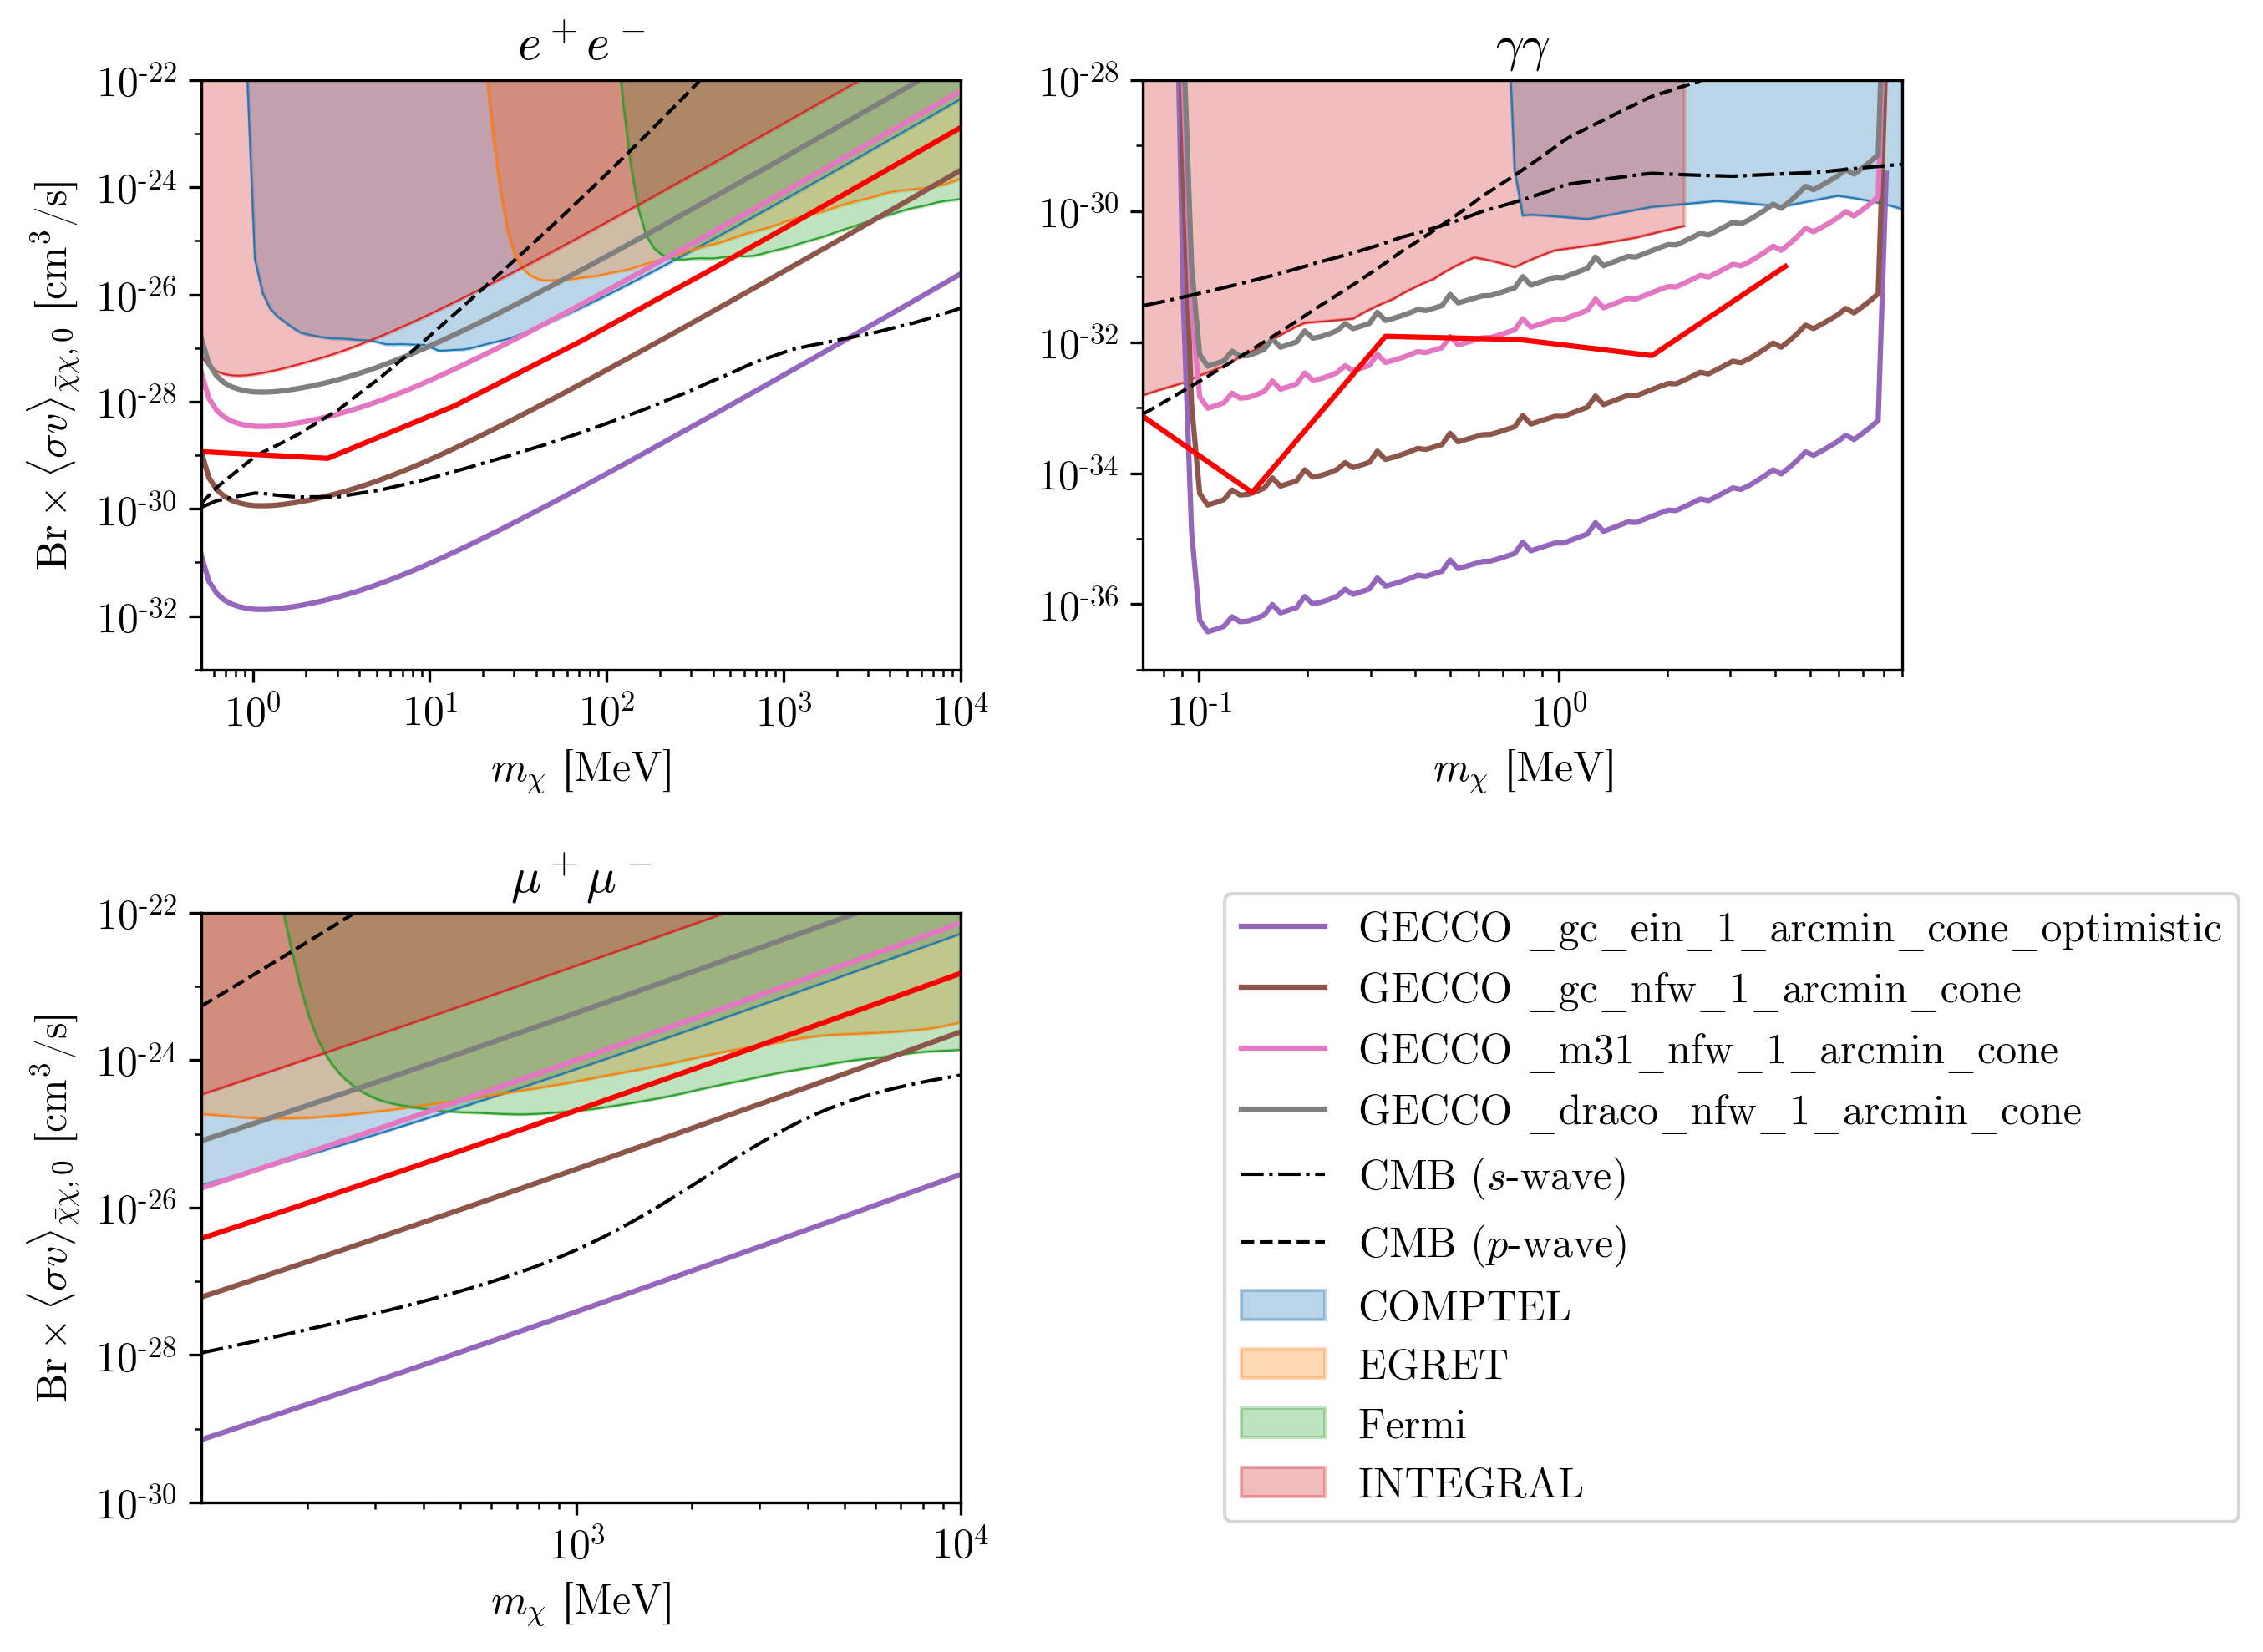

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(fig_dim * 2, fig_dim * 2 * 0.85))

for fs, ax in zip(svs.keys(), axes.flatten()):
    for key, color in zip(svs[fs], mpl_colors):
        if key == "cmb":
            plot_existing(ax, mxs[fs], svs[fs][key], r"CMB ($s$-wave)", color)
            plot_existing(ax, mxs[fs], svs[fs][key], r"CMB ($p$-wave)", color)
        else:
            label = get_constraint_label(key)
            if "gecco" not in key:
                plot_existing(ax, mxs[fs], svs[fs][key], label, color)
            else:
                ax.loglog(mxs[fs], svs[fs][key], label=label, color=color)
    ax.loglog(mxs_integral[fs], svs_integral[fs]["integral_gc_ein_1_arcmin_cone_optimistic"], color="r")

#     plot_integral_secondary(ax, fs)

# Formatting
for fs, ax in zip(svs.keys(), axes.flatten()):
    ax.set_title(get_fs_label(fs))
    ax.set_xlim(mxs[fs][[0, -1]])
    ax.set_ylim(y_lims[fs])
    
    # Ticks
    ax.yaxis.set_major_locator(LogLocator(base=100, numticks=20))
    ax.yaxis.set_minor_locator(LogLocator(base=10, numticks=20))
    ax.yaxis.set_minor_formatter(NullFormatter())
#     ax.xaxis.grid(True, which='major')
#     ax.yaxis.grid(True, which='major')

for ax in [axes[0, 0], axes[0, 1], axes[1, 0]]:
    ax.set_xlabel(r"$m_\chi$ [MeV]")

for ax in axes[:, 0]:
    ax.set_ylabel(
        r"$\mathrm{Br} \times \langle \sigma v \rangle_{\bar{\chi}\chi, 0}$ [cm$^3$/s]"
    )

fig.tight_layout()

axes[-1, -1].set_visible(False)
axes[-1, 0].legend(
    loc="center left", bbox_to_anchor=(1.32, 0.5)
)

# fig.savefig("figures/single_channel_ann.pdf", bbox_inches="tight")

#### Understanding the results

In [94]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle


def make_error_boxes(
    ax, x_lows, x_highs, y_lows, y_highs, facecolor=None, edgecolor='None',
    alpha=0.5, label=None
):
    # Create list for all the error patches
    rects = []
    
    for x_low, x_high, y_low, y_high in zip(
        x_lows, x_highs, y_lows, y_highs
    ):
        rect = Rectangle((x_low, y_low), x_high - x_low, y_high - y_low)
        rects.append(rect)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(
        rects, facecolor=facecolor, alpha=alpha, edgecolor=edgecolor,
        label=label
    )

    # Add collection to axes
    ax.add_collection(pc)

In [100]:
2 * mx * (1 + 1/2 * v_mw**2)

200.0001

/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/single_channel.py:188: RuntimeWarning: invalid value encountered in log
  * (np.log((1 - x) / mu ** 2) - 1)


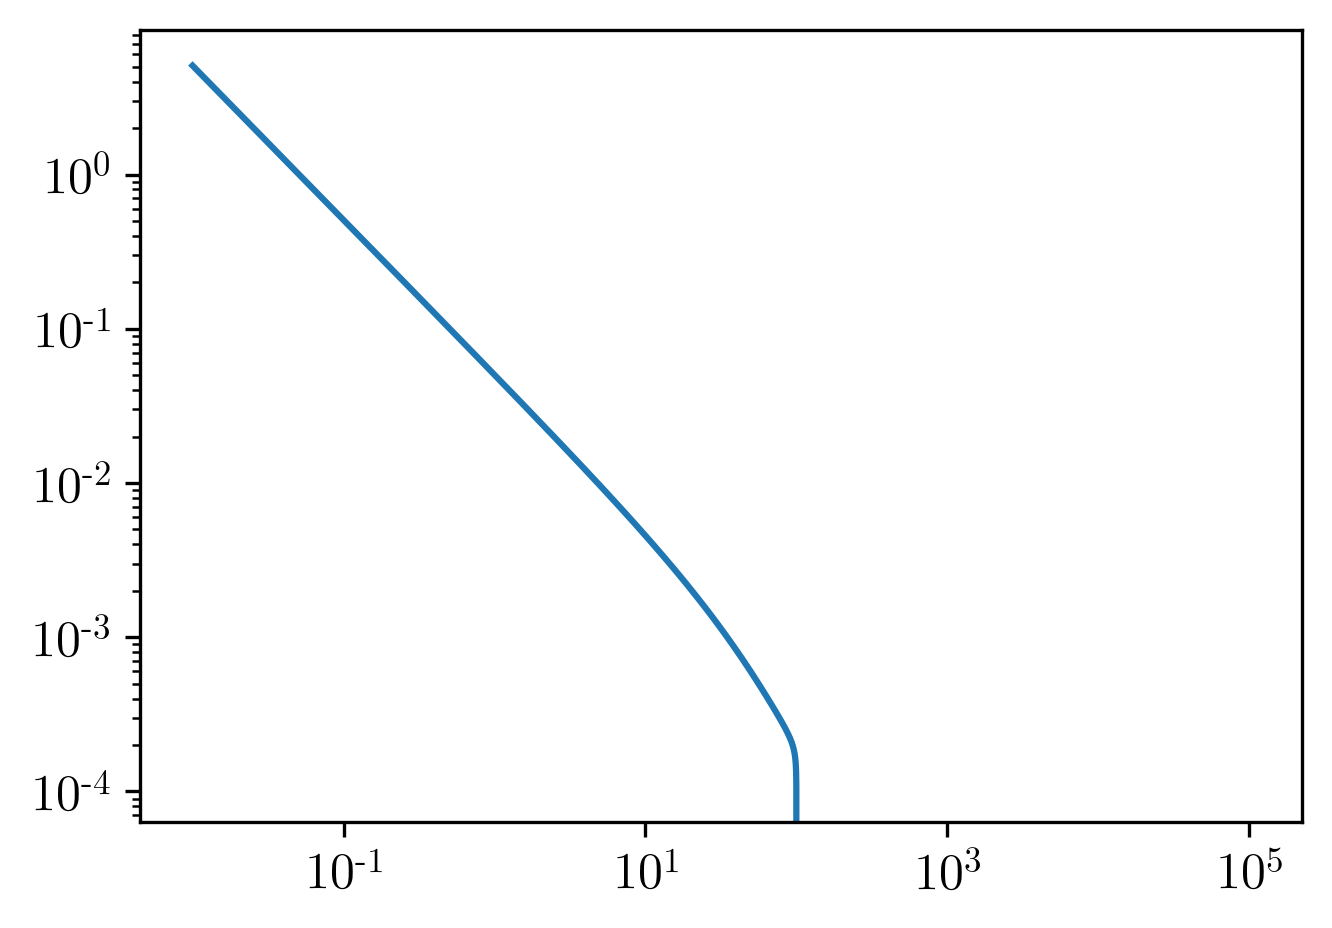

In [102]:
e_gams = np.geomspace(1e-2, 1e5, 5000)
mx = 100.
model = SingleChannelAnn(mx, "e e", 1e-30)
plt.loglog(e_gams, model.total_spectrum(e_gams, 2 * mx * (1 + 1/2 * v_mw**2)))

/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/single_channel.py:188: RuntimeWarning: invalid value encountered in log
  * (np.log((1 - x) / mu ** 2) - 1)
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/single_channel.py:188: RuntimeWarning: invalid value encountered in log
  * (np.log((1 - x) / mu ** 2) - 1)


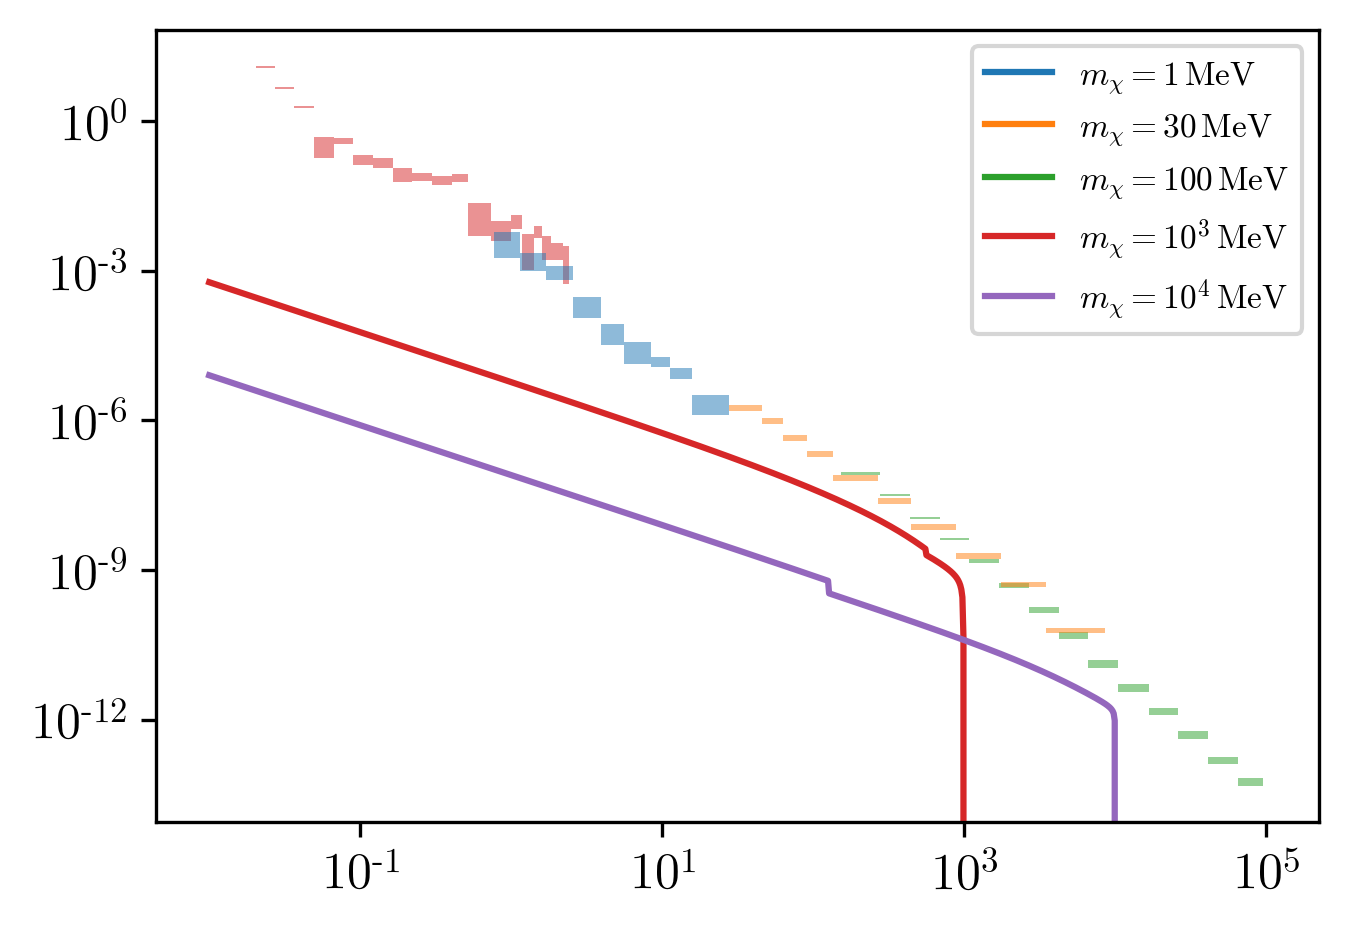

In [123]:
fig, ax = plt.subplots(1, 1)

make_error_boxes(
    ax,
    fermi_diffuse.e_lows,
    fermi_diffuse.e_highs,
    fermi_diffuse.fluxes - fermi_diffuse.lower_errors,
    fermi_diffuse.fluxes + fermi_diffuse.upper_errors,
    mpl_colors[2],
    label="Fermi"
)
make_error_boxes(
    ax,
    integral_diffuse.e_lows,
    integral_diffuse.e_highs,
    integral_diffuse.fluxes - integral_diffuse.lower_errors,
    integral_diffuse.fluxes + integral_diffuse.upper_errors,
    mpl_colors[3],
    label="INTEGRAL"
)
make_error_boxes(
    ax,
    comptel_diffuse.e_lows,
    comptel_diffuse.e_highs,
    comptel_diffuse.fluxes - comptel_diffuse.lower_errors,
    comptel_diffuse.fluxes + comptel_diffuse.upper_errors,
    mpl_colors[0],
    label="COMPTEL"
)
make_error_boxes(
    ax,
    egret_diffuse.e_lows,
    egret_diffuse.e_highs,
    egret_diffuse.fluxes - egret_diffuse.lower_errors,
    egret_diffuse.fluxes + egret_diffuse.upper_errors,
    mpl_colors[1],
    label="EGRET"
)

e_gams = np.geomspace(1e-2, 1e5, 1000)

mx = 1e0
model = SingleChannelAnn(mx, "mu mu", 1.)
ax.plot(
    e_gams, 100/mx**2 * model.total_spectrum(e_gams, 2 * mx * (1 + 1/2 * v_mw**2)),
    label=r"$m_\chi = 1\, \mathrm{MeV}$"
)

mx = 30
model = SingleChannelAnn(mx, "mu mu", 1.)
ax.plot(
    e_gams, 100/mx**2 * model.total_spectrum(e_gams, 2 * mx * (1 + 1/2 * v_mw**2)),
    label=r"$m_\chi = 30\, \mathrm{MeV}$"
)

mx = 100
model = SingleChannelAnn(mx, "mu mu", 1.)
ax.plot(
    e_gams, 100/mx**2 * model.total_spectrum(e_gams, 2 * mx * (1 + 1/2 * v_mw**2)),
    label=r"$m_\chi = 100\, \mathrm{MeV}$"
)

mx = 1e3
model = SingleChannelAnn(mx, "mu mu", 1.)
ax.plot(
    e_gams, 100/mx**2 * model.total_spectrum(e_gams, 2 * mx * (1 + 1/2 * v_mw**2)),
    label=r"$m_\chi = 10^3\, \mathrm{MeV}$"
)

mx = 1e4
model = SingleChannelAnn(mx, "mu mu", 1.)
ax.plot(
    e_gams, 100/mx**2 * model.total_spectrum(e_gams, 2 * mx * (1 + 1/2 * v_mw**2)),
    label=r"$m_\chi = 10^4\, \mathrm{MeV}$"
)

ax.legend(fontsize=8)
ax.autoscale()
ax.set_xscale("log")
ax.set_yscale("log")

## Model-independent decay constraints

### Compute

In [138]:
fss = ["e e", "g g", "mu mu", "pi pi"]
n_mxs = 100
mxs = {
    "e e": np.geomspace(2 * m_e, 1e4, n_mxs),
    "g g": np.geomspace(1.2e-1, 2e1, n_mxs),
    "mu mu": np.geomspace(2 * m_mu, 1e4, n_mxs),
    "pi pi": np.geomspace(2 * m_pi, 1e4, n_mxs),
}

# Compute
gammas = {}
for fs in fss:
    model = SingleChannelDec(1., fs, 1.)
    gammas[fs] = get_constraints(
        model, mxs[fs], nt_targets=nt_targets_dec, cmb=False
    )

# Clean up any extremely weak constraints
for key in gammas:
    for k in gammas[key]:
        gammas[key][k][gammas[key][k] > 1] = np.inf

/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/single_channel.py:359: RuntimeWarning: invalid value encountered in log
  * (np.log((1 - x) / mu ** 2) - 1)
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/background_model.py:48: UserWarning: The gamma ray background model is not applicable for energy 0.100000 MeV.
  warnings.warn(


/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:122: RuntimeWarning: overflow encountered in double_scalars
  self,
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:233: RuntimeWarning: divide by zero encountered in double_scalars


/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/decay.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.Spectrum(photon_energies, muon_energy)


/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/single_channel.py:340: RuntimeWarning: invalid value encountered in log
  * (np.log((1 - x) / mu ** 2) - 1)
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/decay.py:141: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)


In [139]:
# Save constraints
np.savez("data/single_channel_dec/gammas.npz", **gammas)
np.savez("data/single_channel_dec/mxs.npz", **mxs)

### Plot

In [280]:
gammas = dict(
    np.load("data/single_channel_dec/gammas.npz", allow_pickle=True)
)
gammas = {k: v.item() for k, v in gammas.items()}
mxs = dict(
    np.load("data/single_channel_dec/mxs.npz", allow_pickle=True)
)

# Manually trim down the gg constraints to remove binning artifacts
idxs_gg_comptel = [48, 49, 50, 51, 58, 66, 74, 82, 89, 97]
gammas["g g"]["comptel"] = np.interp(
    mxs["g g"],
    mxs["g g"][idxs_gg_comptel],
    gammas["g g"]["comptel"][idxs_gg_comptel],
    left=np.nan,
    right=np.nan
)
idxs_gg_integral = [3, 8, 13, 18, 23, 29, 34, 39, 44, 49, 54, 59, 64, 70]
gammas["g g"]["integral"] = np.interp(
    mxs["g g"],
    mxs["g g"][idxs_gg_integral],
    gammas["g g"]["integral"][idxs_gg_integral],
    left=np.nan,
    right=np.nan
)
mxs["g g"] = mxs["g g"][3:-2]
gammas["g g"] = {k: v[3:-2] for k, v in gammas["g g"].items()}

# Load CMB constraints
mxs_cmb, taus_cmb = {}, {}
for fs in ["g g", "e e", "mu mu"]:
    data = np.loadtxt(
        f"data/cmb_dec/{fs.replace(' ', '_')}.csv", unpack=True
    )
    mxs_cmb[fs] = data[0] * 1e3  # GeV -> MeV
    taus_cmb[fs] = data[1]

y_lims = {
    "e e": (1e22, 1e27),
    "g g": (1e25, 1e31),
    "mu mu": (1e22, 1e26),
    "pi pi": (1e22, 1e26),
}

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


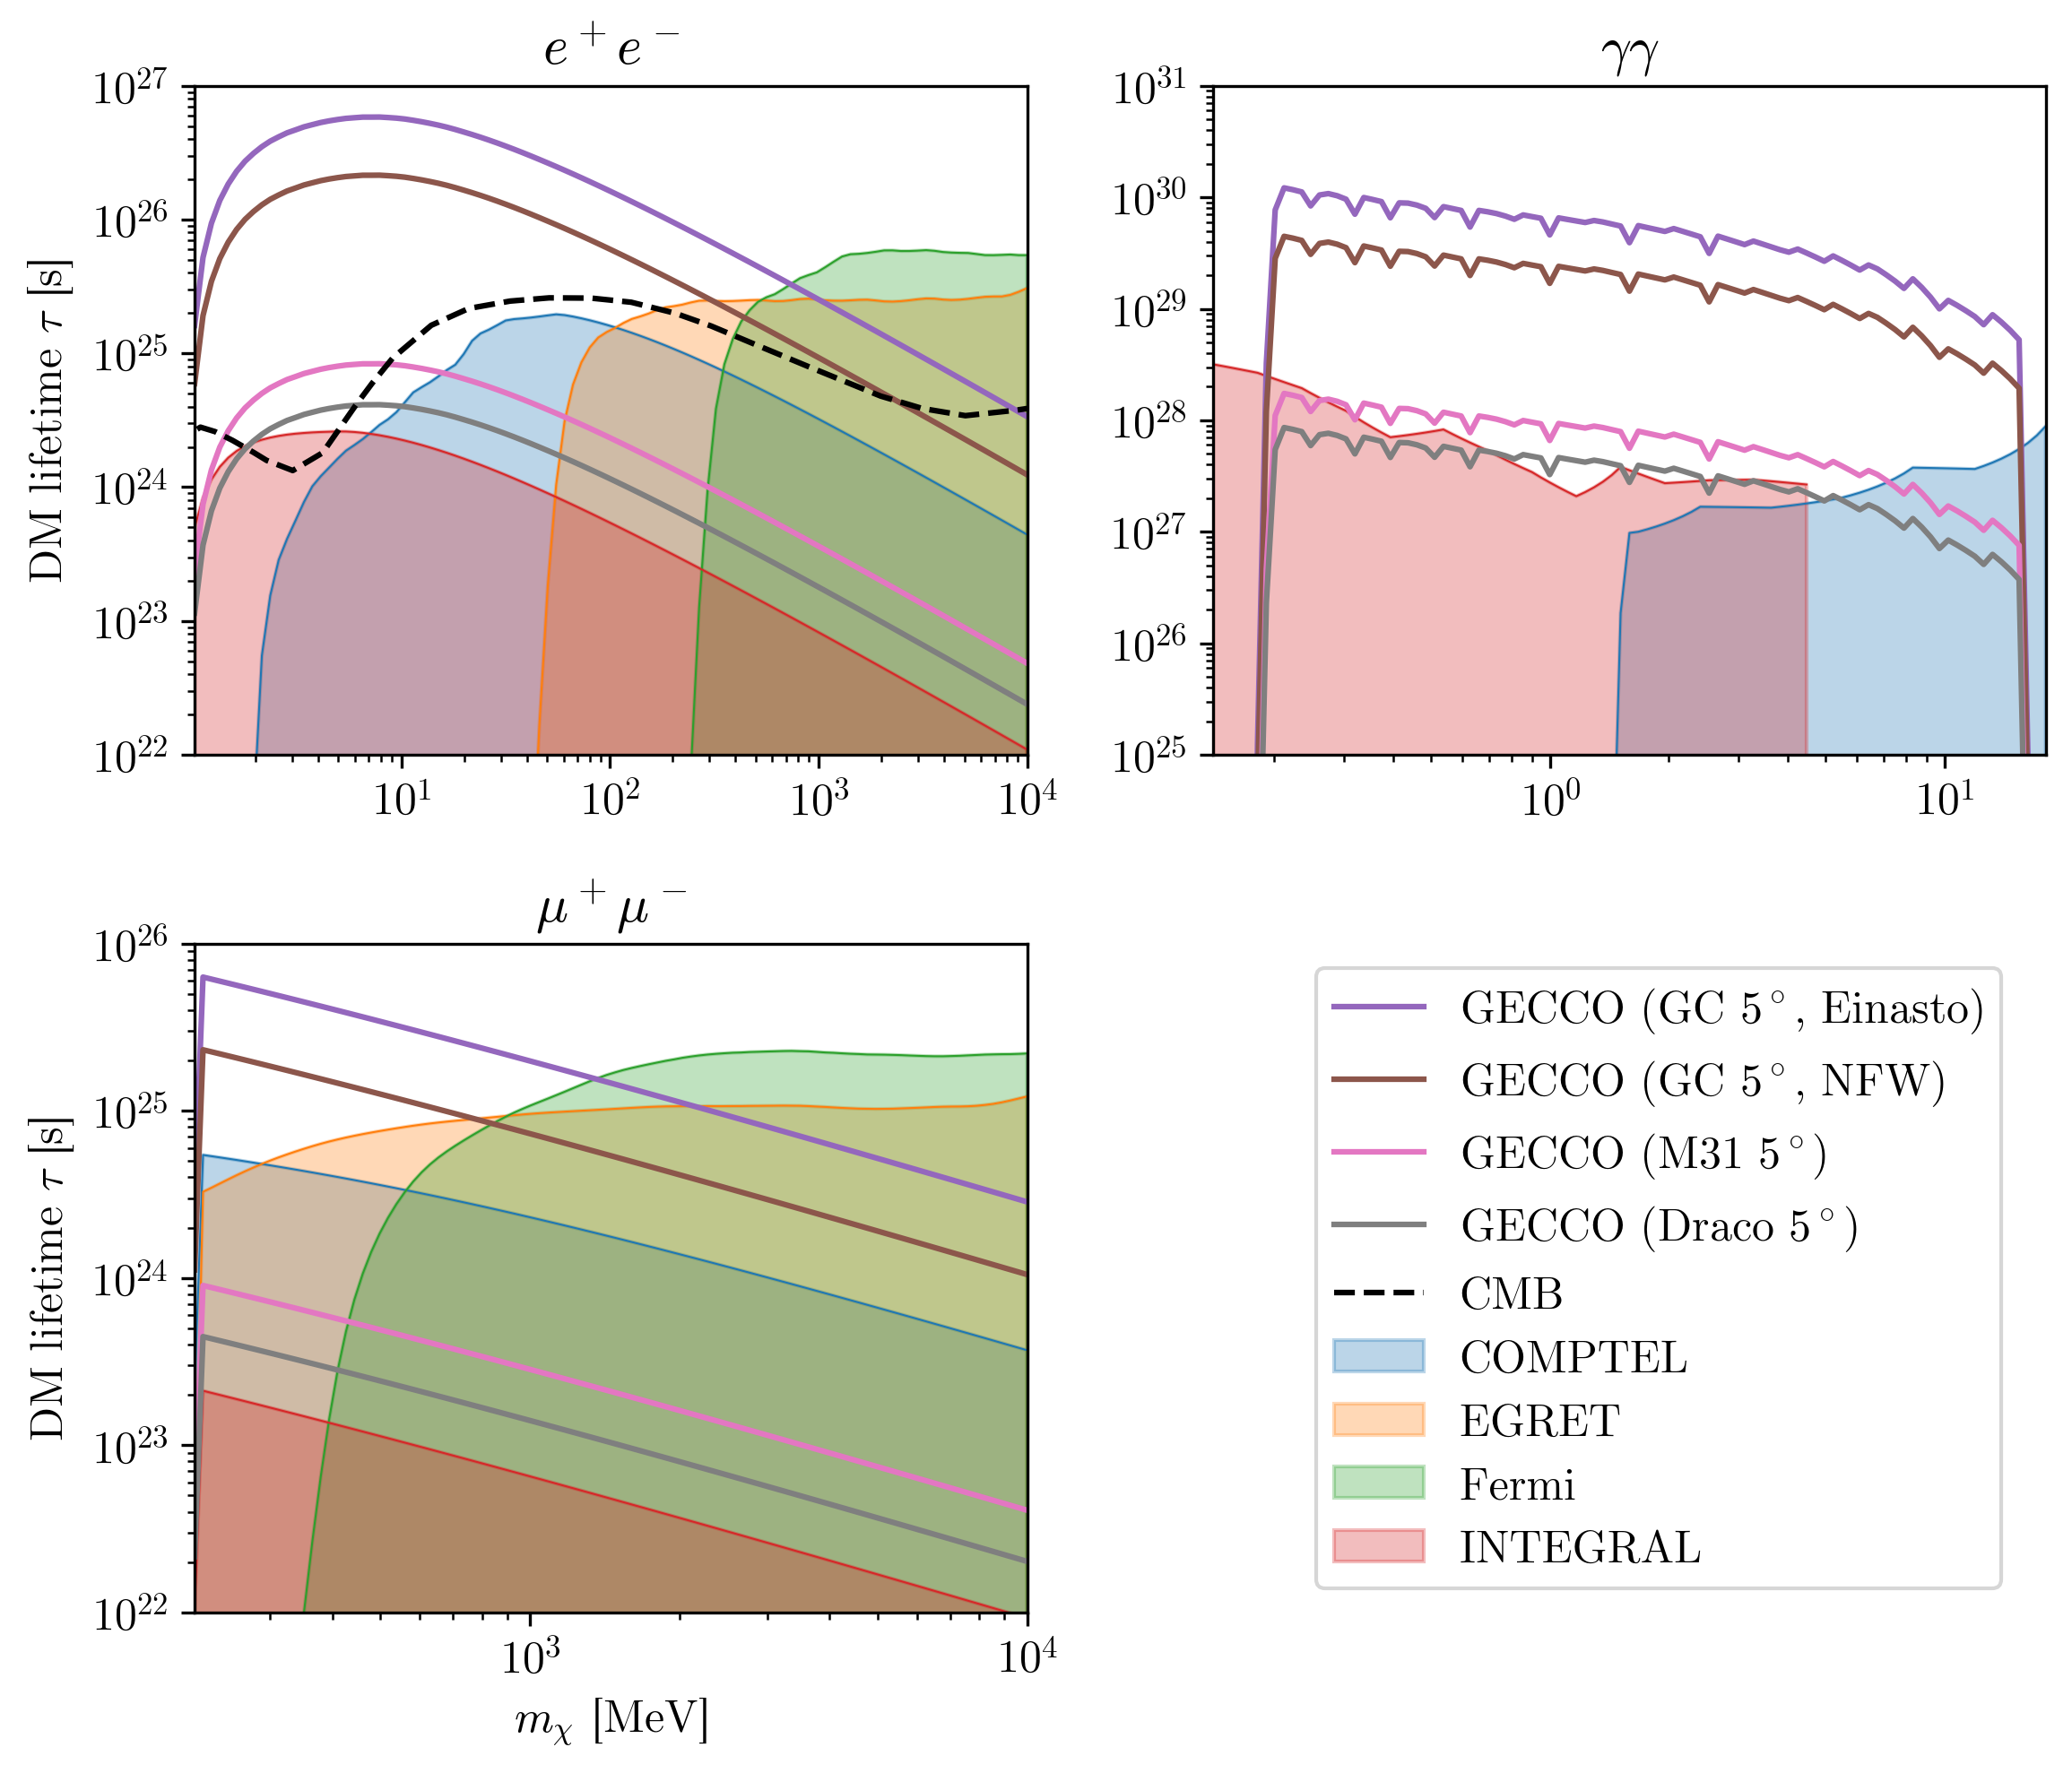

In [285]:
fig, axes = plt.subplots(2, 2, figsize=(fig_dim * 2, fig_dim * 2 * 0.85))

for fs, ax in zip(gammas.keys(), axes.flatten()):
    for key, color in zip(gammas[fs], mpl_colors):
        label = get_constraint_label(key)

        if "gecco" not in key:
            plot_existing(ax, mxs[fs], 1 / gammas[fs][key], label, color)
        else:
            ax.loglog(mxs[fs], 1 / gammas[fs][key], label=label, color=color)
    
    if fs in mxs_cmb:
        ax.loglog(mxs_cmb[fs], taus_cmb[fs], "--k", label="CMB")

# Formatting
for fs, ax in zip(gammas.keys(), axes.flatten()):
    ax.set_title(get_fs_label(fs))
    ax.set_xlim(mxs[fs][[0, -1]])
    ax.set_ylim(y_lims[fs])
#     ax.xaxis.grid(True, which='major')
#     ax.yaxis.grid(True, which='major')

for ax in axes[-1, :]:
    ax.set_xlabel(r"$m_\chi$ [MeV]")

for ax in axes[:, 0]:
    ax.set_ylabel(r"DM lifetime $\tau$ [s]")

fig.tight_layout()

axes[-1, -1].set_visible(False)
axes[-1, 0].legend(
    loc="center left", bbox_to_anchor=(1.32, 0.5)
)

fig.savefig("figures/single_channel_dec.pdf", bbox_inches="tight")

## Higgs portal model

### Utils

In [11]:
def hp_max_sv(mx, ms, gsxx_max=4*np.pi):
    """
    Computes max value of <sigma v>.
    """
    def fn(mx, ms):
        hp = HiggsPortal(mx, ms, gsxx_max, 1)
        return hp.annihilation_cross_sections(
            2 * hp.mx * (1 + 0.5 * v_mw**2)
        )["total"] * v_mw * sv_inv_MeV_to_cm3_per_s
    return np.vectorize(fn)(mx, ms)


def hp_pheno_constr(mx, ms, sv, gsxx_max=4*pi):
    """
    Determines whether any values of stheta are consistent with pheno constraints
    at the given point in the ID plane.
    """
    def fn(mx, ms, sv):
        assert ms > mx
        hp = HiggsPortal(mx, ms, 1, 1)
        sv_1 = hp.annihilation_cross_sections(
            2 * hp.mx * (1 + 0.5 * v_mw**2)
        )["total"] * v_mw * sv_inv_MeV_to_cm3_per_s

        # Find smallest stheta compatible with <sigma v> for the given
        # gsxx_max
        stheta_min = np.sqrt(sv / sv_1) / gsxx_max
        if stheta_min > 0.999:
            return -1e100
        
        stheta_grid = np.geomspace(stheta_min, 0.999, 20)
        constr_mins = np.full_like(stheta_grid, np.inf)
        gsxxs = np.zeros_like(stheta_grid)
        for i, stheta in enumerate(stheta_grid):
            hp.stheta = stheta
            hp.gsxx = np.sqrt(sv / sv_1) / hp.stheta
            gsxxs[i] = hp.gsxx
            # Figure out strongest constraint
            constr_mins[i] = np.min([fn() for fn in hp.constraints().values()])

        # Check if (mx, ms, sv) point is allowed for some (gsxx, stheta) combination
        return constr_mins.max()

    return np.vectorize(fn)(mx, ms, sv)

### Compute

In [82]:
ms_over_mxs = [0.5, 1.5]#, 1.1]
mxs = [
    np.geomspace(0.1, 250, 40) if r > 1 else np.geomspace(0.1, 1000, 40)
    for r in ms_over_mxs
]
mss = [mx * ms_over_mx for mx, ms_over_mx in zip(mxs, ms_over_mxs)]
models = [HiggsPortal(mx=1, ms=1, gsxx=1, stheta=1) for _ in ms_over_mxs]

In [83]:
svs = [{} for _ in mxs]
for i in range(len(mxs)):
    svs[i] = get_constraints(models[i], mxs[i], mss[i])
    # Clean up any extremely weak constraints
    for key in svs[i]:
        svs[i][key][svs[i][key] > 1] = np.inf

/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:105: RuntimeWarning: divide by zero encountered in true_divide
  sv_lims = Phi_maxs / Phi_dms_un
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_gamma_ray_limits.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  bound = prefactor * n_sigma / np.nanmax(snrs[:, 2])
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/background_model.py:48: UserWarning: The gamma ray background model is not applicable for energy 101215.995655 MeV.
  warnings.warn(
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/background_model.py:48: UserWarning: The gamma ray background model is not applicable for energy 10017.780306 MeV.
  warnings.warn(
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/decay.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.Spectrum(photon_energies, muon_energy)
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/decay.py:141: Integrat

In [84]:
beep()

In [40]:
# Save constraints
np.savez("data/higgs_portal_matching/svs.npz", svs=svs)
np.savez("data/higgs_portal_matching/mxs.npz", mxs=mxs)
np.savez("data/higgs_portal_matching/mss.npz", mss=mss)

### Plot

In [12]:
# Ignore the ms = 1.1 mx data
svs = np.load("data/higgs_portal_matching/svs.npz", allow_pickle=True)["svs"]
mxs = np.load("data/higgs_portal_matching/mxs.npz", allow_pickle=True)["mxs"]
mss = np.load("data/higgs_portal_matching/mss.npz", allow_pickle=True)["mss"]

# Compute pheno constraints over (mx, <sigma v>) grid
sv_grid = np.geomspace(1e-40, 1e-22, 50)
mx_mg, sv_mg = np.meshgrid(mxs[1], sv_grid)
ms_mg = np.meshgrid(mss[1], sv_grid)[0]
sv_pheno = hp_pheno_constr(mx_mg, ms_mg, sv_mg)

In [13]:
from hazma.relic_density import relic_density

In [14]:
def get_sv_hp_relic(mx, ms, stheta=1):
    def fn(gsxx):
        hp = HiggsPortal(mx, ms, gsxx, stheta)
        return relic_density(hp) - 0.22
    
    if ms < mx:
        bracket = (1e-5, 4*np.pi)
    else:
        bracket = (1e-4, 1e8)
    gsxx = root_scalar(fn, bracket=bracket, xtol=1e-100, rtol=1e-3).root
    hp = HiggsPortal(mx, ms, gsxx, stheta)
    return hp.annihilation_cross_sections(
        2 * hp.mx * (1 + 0.5 * v_mw**2)
    )["total"] * v_mw * sv_inv_MeV_to_cm3_per_s


# Compute thermal relic cross section
for i in range(len(mxs)):
    svs[i]["relic"] = np.vectorize(get_sv_hp_relic)(mxs[i], mss[i], 1)

/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/relic_density/__init__.py:597: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return pf * quad(integrand, xstar, 100 * xstar)[0]


Text(7, 1e-29, '$(g_{S\\chi}, s_\\theta) = (4\\pi, 1)$')

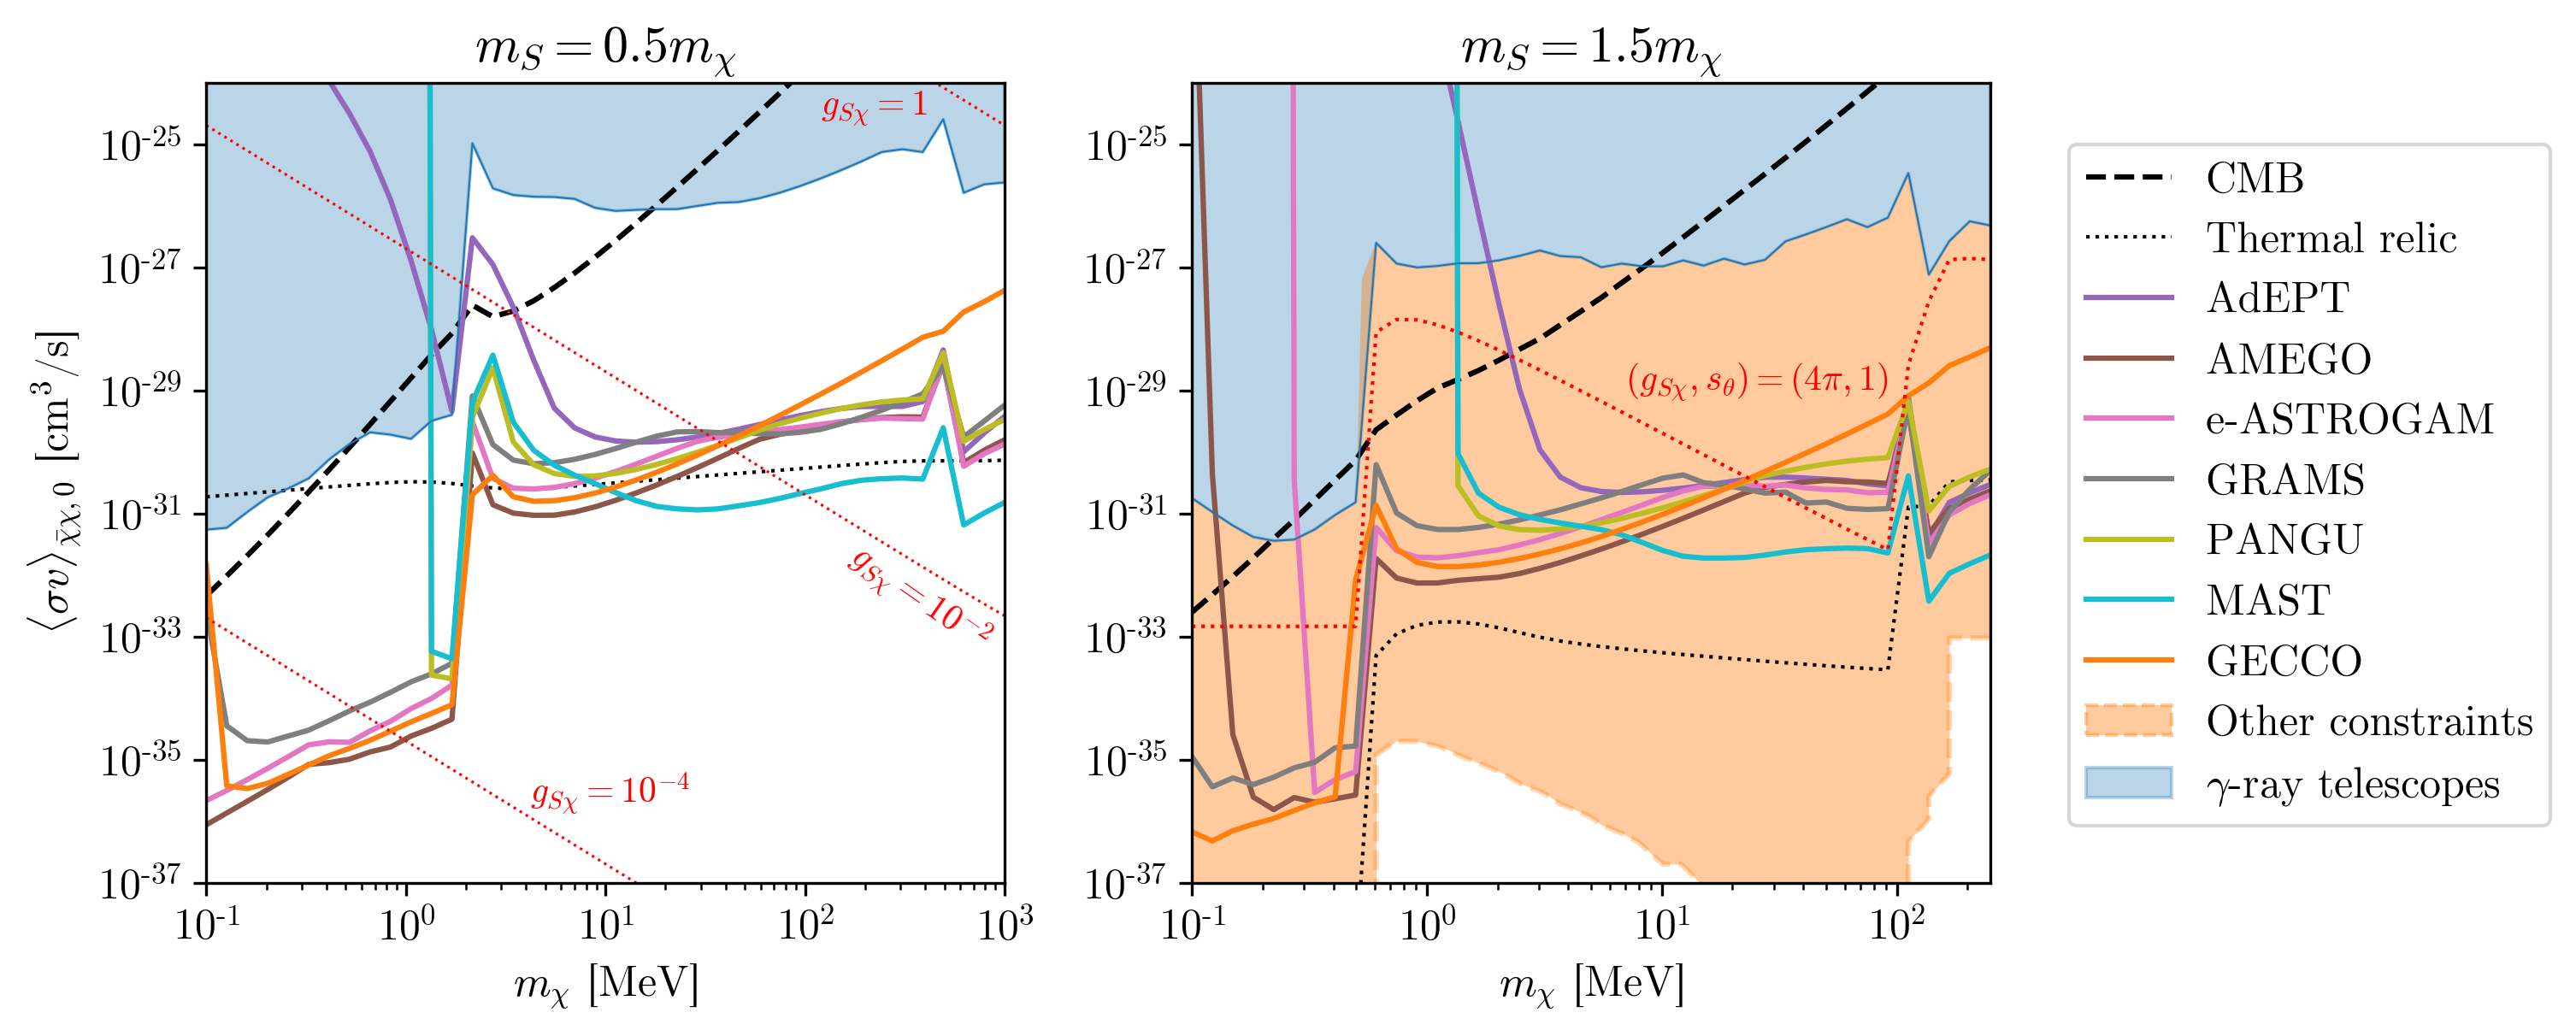

In [19]:
fig, axes = plt.subplots(
    1, 3, figsize=(3 * fig_dim, 1.25 * fig_dim * 0.85)
)

for i, ax in enumerate(axes[:-1]):
    # CMB (p-wave!)
    v_cmbs = 2e-4 * (0.235) * (1 / mxs[i]) * np.sqrt(1e-4 / x_kd)
    ax.plot(
        mxs[i], svs[i]["cmb"] * (v_mw / v_cmbs)**2, "--k", label=r"CMB"
    )
            
    ax.plot(
        mxs[i], svs[i]["relic"], ":k", linewidth=1,
        label="Thermal relic" if i == 1 else None
    )
    
    # Projections
    for key, color in zip(svs[i], mpl_colors + mpl_colors):
        if any(
            [nt in key for nt in [
                    "adept", "amego", "e_astrogam", "grams", "pangu", "mast", "gecco"
                ]
            ]
        ):
            _svs = svs[i][key]
            _svs[np.isinf(_svs)] = 1e100
            ax.loglog(
                mxs[i], _svs, label=get_constraint_label(key), color=color
            )
    
    # Envelope of existing gamma-ray constraints
    sv_envelope = np.stack(
        [svs[i][k] for k in ["comptel", "fermi", "egret", "integral"]]
    ).min(0)
    plot_existing(
        ax, mxs[i], sv_envelope, r"$\gamma$-ray telescopes",
        mpl_colors[0]
    )
    
    if mss[i][0] / mxs[i][0] < 1:  # xx -> ss
        # Contours of constant gsxx
        for gsxx in [1, 1e-2, 1e-4]:
            ax.plot(
                mxs[i], hp_max_sv(mxs[i], mss[i], gsxx),
                ":r", linewidth=0.75,
            )
    else:  # xx -> SM: highly constrained!
        # Plot pheno constraints
        cs = ax.contour(
            mxs[i], sv_grid, sv_pheno, levels=[-1e200, 0], colors=[mpl_colors[1]],
            linestyles=["--"], alpha=0.3
        )
        mxs_pheno, svs_pheno = cs.collections[1].get_paths()[0].vertices.T
        ax.fill_between(
            mxs_pheno, svs_pheno, np.interp(mxs_pheno, mxs[i], sv_envelope),
            color=mpl_colors[1], alpha=0.4, linewidth=0
        )
        # Add proxy artist
        ax.patches.append(
            plt.Rectangle(
                (0, 0), 0, 0,
                color=mpl_colors[1],
                alpha=0.4,
                label="Other constraints",
                linestyle="--"
            )
        )
        
        # (gsxx, stheta) = (4*pi, 1)
        ax.plot(
            mxs[i], hp_max_sv(mxs[i], mss[i]), ":r", linewidth=1,
        )
    
    # Formatting
    ax.set_title(r"$m_S = %.1f m_\chi$" % (mss[i][0] / mxs[i][0]))
    ax.set_xlim(mxs[i][[0, -1]])
    ax.set_ylim(1e-37, 1e-24)
    ax.set_xlabel(r"$m_\chi$ [MeV]")

axes[0].set_ylabel(
    r"$\langle \sigma v \rangle_{\bar{\chi}\chi, 0}$ [cm$^3$/s]"
)

plt.tight_layout()

# Put legend on last axis
axes[-1].set_visible(False)
axes[-2].legend(
    loc='upper center', bbox_to_anchor=(1.4, 0.95), fancybox=True, ncol=1
)

axes[0].text(1.2e2, 3e-25, r"$g_{S\chi} = 1$", color="r", fontsize=10, alpha=1)
axes[0].text(1.5e2, 6e-34, r"$g_{S\chi} = 10^{-2}$", rotation=-35, color="r", fontsize=10, alpha=1)
axes[0].text(4.2e0, 2e-36, r"$g_{S\chi} = 10^{-4}$", color="r", fontsize=10, alpha=1)
axes[1].text(7, 1e-29, r"$(g_{S\chi}, s_\theta) = (4\pi, 1)$", color="r", fontsize=10)

# fig.savefig("figures/higgs_portal_all_telescopes.pdf", bbox_inches="tight")

## Effective areas

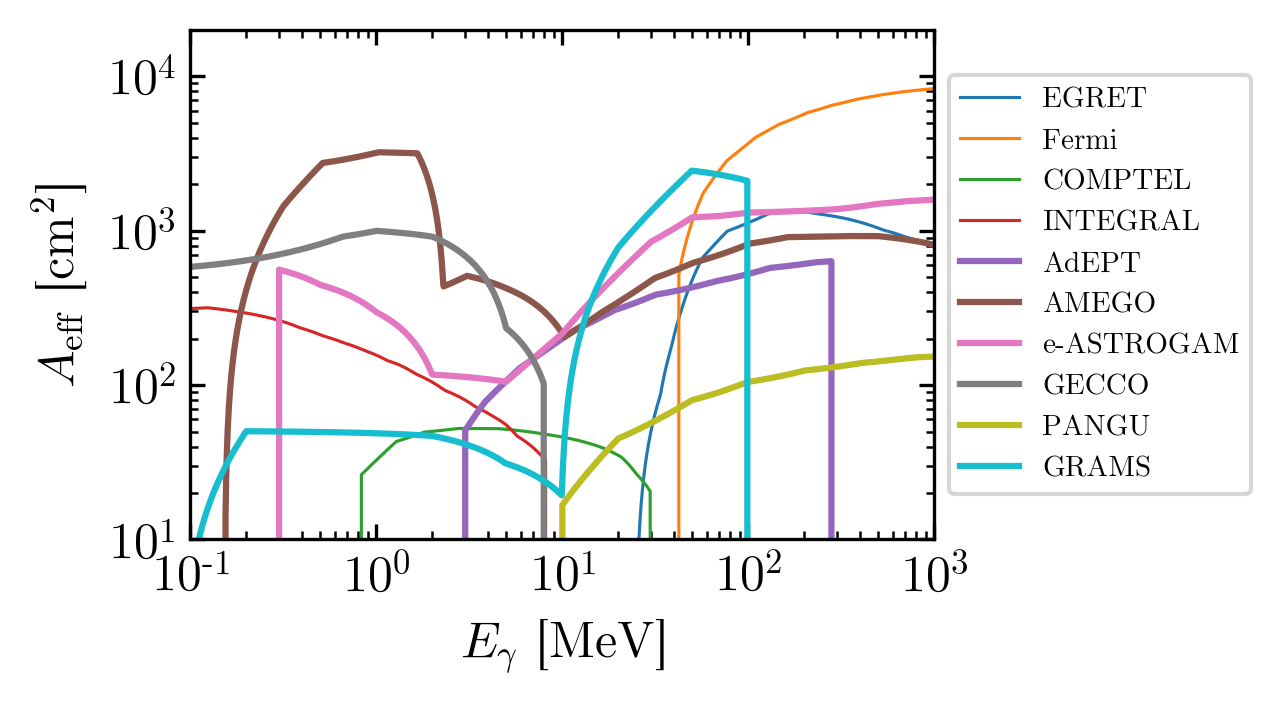

In [5]:
plt.figure(figsize=(4, 2.25))

e_gams = np.geomspace(0.1, 1e3, 2000)

# telescope_colors = mpl_colors

plt.plot(
    e_gams,
    A_eff_egret(e_gams),
#     # color=telescope_colors["egret"],
    label="EGRET",
    linewidth=0.75,
)
plt.plot(
    e_gams,
    A_eff_fermi(e_gams),
    # color=telescope_colors["fermi"],
    label="Fermi",
    linewidth=0.75,
)
plt.plot(
    e_gams,
    A_eff_comptel(e_gams),
    # color=telescope_colors["comptel"],
    label="COMPTEL",
    linewidth=0.75,
)
plt.plot(
    e_gams,
    A_eff_integral(e_gams),
    # color=telescope_colors["comptel"],
    label="INTEGRAL",
    linewidth=0.75,
)
plt.plot(
    e_gams, A_eff_adept(e_gams),
    # color=telescope_colors["adept"],
    label="AdEPT"
)
plt.plot(
    e_gams, A_eff_amego(e_gams),
    # color=telescope_colors["amego"],
    label="AMEGO"
)
plt.plot(
    e_gams,
    A_eff_e_astrogam(e_gams),
    # color=telescope_colors["e_astrogam"],
    label="e-ASTROGAM",
)
# plt.plot(
#     e_gams,
#     A_eff_e_astrogam(e_gams),
#     # color=telescope_colors["e_astrogam"],
#     label="e-ASTROGAM",
# )
plt.plot(
    e_gams, A_eff_gecco(e_gams),
    # color=telescope_colors["gecco"],
    label="GECCO"
)
plt.plot(
    e_gams, A_eff_pangu(e_gams),
    # color=telescope_colors["pangu"],
    label="PANGU"
)
plt.plot(
    e_gams, A_eff_grams(e_gams),
    # color=telescope_colors["grams"],
    label="GRAMS"
)

plt.xlim(e_gams[[0, -1]])
plt.ylim(1e1, 2e4)
plt.xscale("log")
plt.yscale("log")
plt.gca().xaxis.set_ticks_position("both")
plt.gca().yaxis.set_ticks_position("both")
plt.gca().tick_params(axis="both", which="both", direction="in")
plt.xlabel(r"$E_\gamma$ [MeV]")
plt.ylabel(r"$A_\mathrm{eff}$ [cm$^2$]")

box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=7)

# plt.savefig("figures/a_effs.pdf", bbox_inches="tight")

## Relic abundance junk

In [147]:
v_mw = 0.001

def get_hp_relic(mx, ms, stheta, semi_analytic=True):
    """
    Get relic abundance for Higgs portal model where the DM annihilates
    into mediators.
    """
    def fn(log_gsxx):
        hp = HiggsPortal(mx, ms, 10**log_gsxx, stheta)
        hp.gsxx = 10**log_gsxx
        return relic_density(hp, semi_analytic) - 0.22

    if ms < mx:
        bracket = [-5, np.log10(4 * np.pi)]
    else:
        bracket = [-5, 8]

    sol = root_scalar(fn, bracket=bracket, xtol=1e-100, rtol=1e-4)
    if not sol.converged:
        raise Exception("didn't converge")
    else:
        gsxx_relic = 10**sol.root
    
    # Compute <sigma v> at present
    hp = HiggsPortal(mx, ms, gsxx_relic, stheta)
    sigma = hp.annihilation_cross_sections(
        2 * hp.mx * (1 + 1/2 * v_mw**2)
    )["total"]
    sv = sigma * v_mw * sv_inv_MeV_to_cm3_per_s
    b = sigma / v_mw

    return sv, gsxx_relic, b

In [148]:
from hazma.parameters import plank_mass
from hazma.relic_density import compute_xstar, sm_sqrt_gstar

In [149]:
from scipy.integrate import quad

def n_eq(temp, m, g, kind):
    def _fn(temp):
        x = m / temp
        if kind == "boson":
            integrand = lambda xi: xi**2 / (np.exp(np.sqrt(xi**2 + x**2)) - 1)
        elif kind == "fermion":
            integrand = lambda xi: xi**2 / (np.exp(np.sqrt(xi**2 + x**2)) + 1)

        coeff = g / (2 * np.pi**2) * temp**3
        return coeff * quad(integrand, 0, 5e2, epsabs=0, epsrel=1e-5, points=[1])[0]
    
    return np.vectorize(_fn)(temp)

/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/scalar_mediator/_scalar_mediator_cross_sections.py:469: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return tcs_xx_to_ss(
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/scalar_mediator/_scalar_mediator_cross_sections.py:511: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return tcs_ss_to_xx(
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/scalar_mediator/_scalar_mediator_cross_sections.py:511: IntegrationWarning: The o

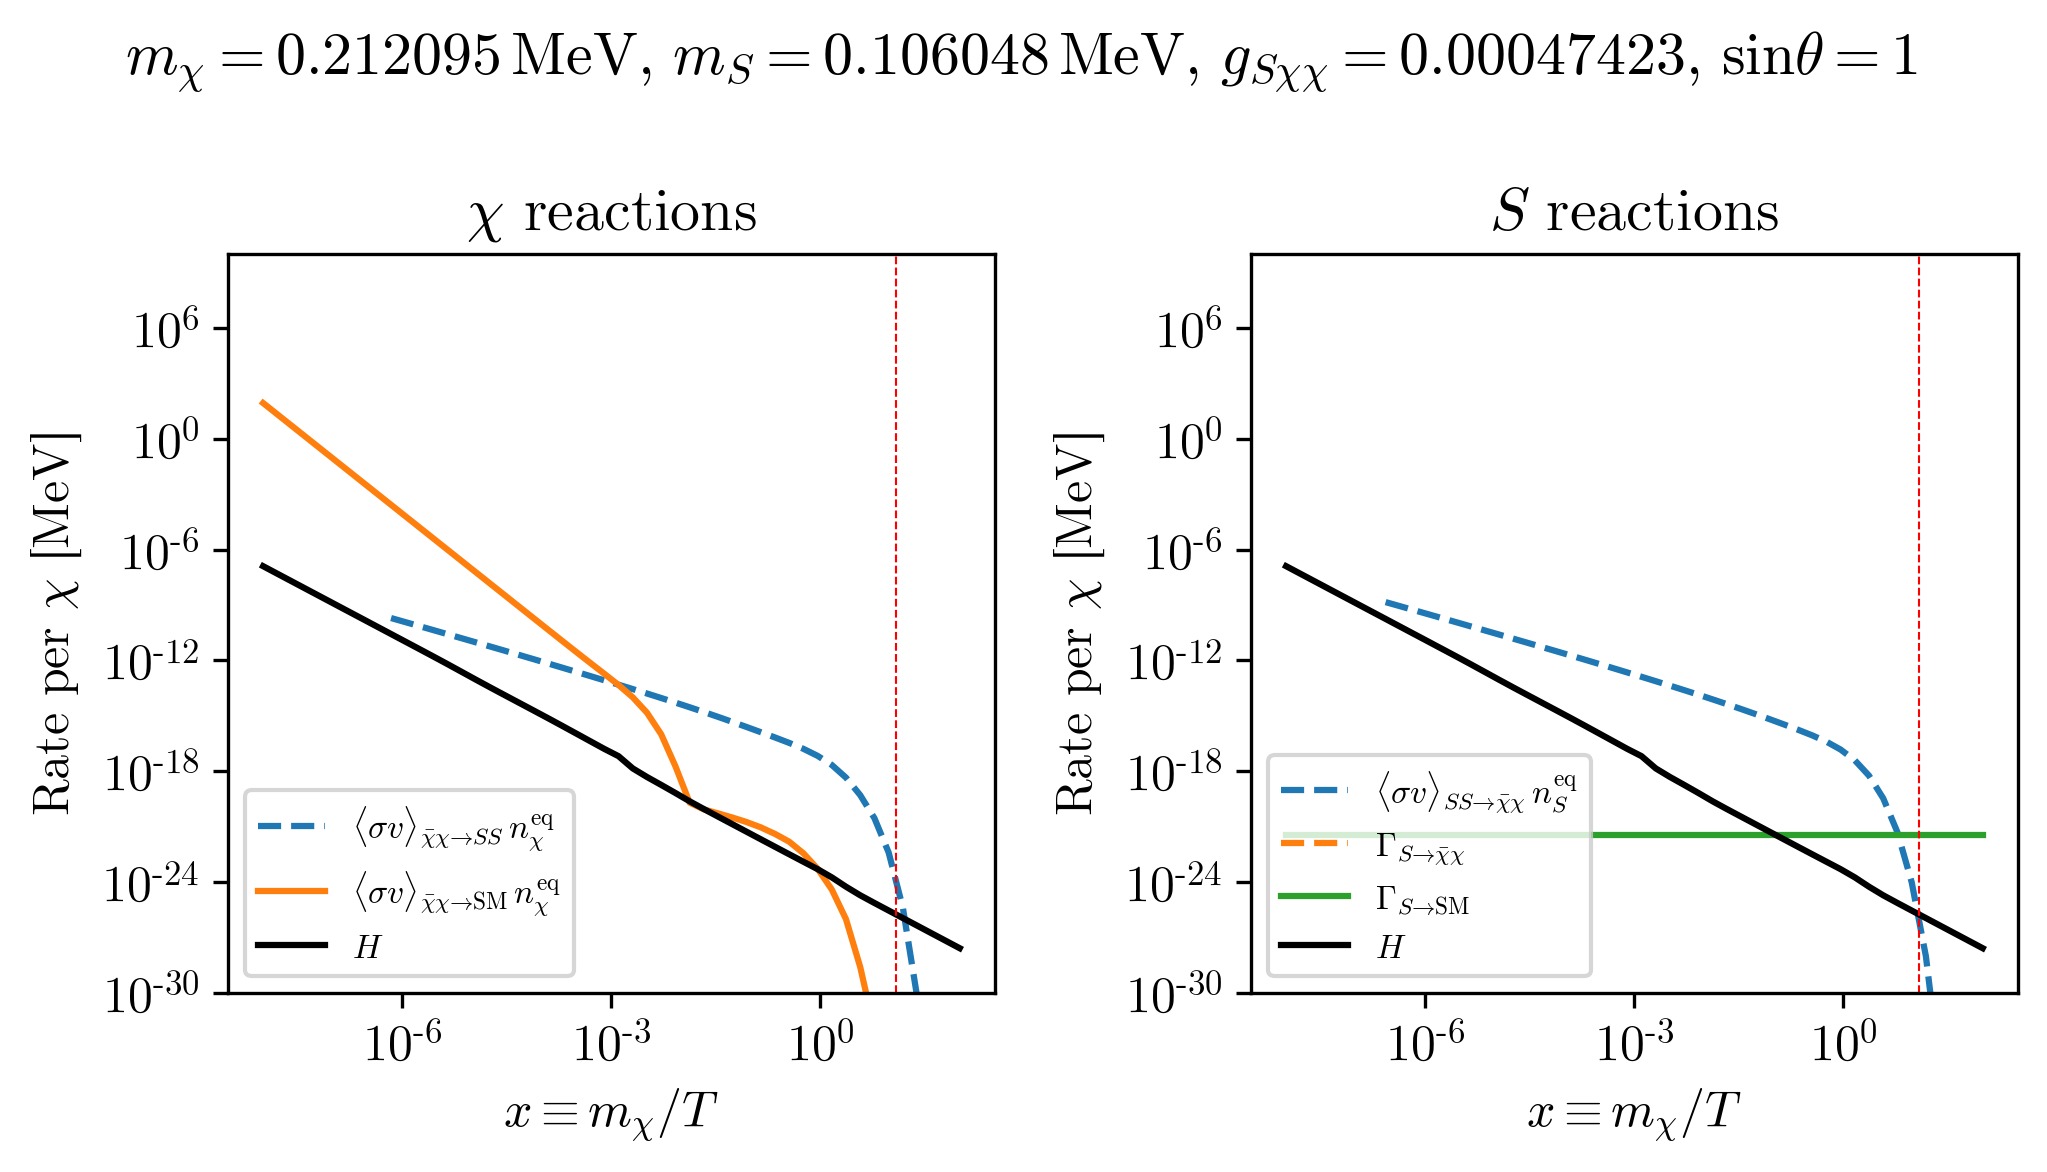

In [151]:
# Compute
i = 0
j = 4
stheta = 1
gsxx = get_hp_relic(mxs[i][j], mss[i][j], stheta)[1]
# gsxx = 1
hp = HiggsPortal(mxs[i][j], mss[i][j], gsxx, stheta)
xs = np.geomspace(0.00000001, 100)  # m / T
temps = hp.mx / xs

svs_xxs = np.array([hp.thermal_cross_section(x) for x in xs])
svs_xx_to_sss = np.array([hp.thermal_cross_section_ss(x) for x in xs])
svs_xx_to_sms = np.array([hp.thermal_cross_section_sm(x) for x in xs])
svs_ss_to_xxs = np.array([
    hp.thermal_cross_section_ss_to_xx(hp.ms / temp) for temp in temps
])
n_eq_ss = n_eq(temps, hp.ms, 1, "boson")
n_eq_xs = n_eq(temps, hp.mx, 2 * 2, "fermion")

m_f = 4.2e3 # 173e3
g_f = 3  # color factor
svs_ff_to_xxs = np.array([
    hp.thermal_cross_section_ff_to_xx(hp.ms / temp, m_f) for temp in temps
])
n_eq_fs = n_eq(temps, m_f, 2 * g_f * 2, "fermion")

# Plot
hbar = 6.582e-22  # s * MeV
plt.figure(figsize=(7, 4))
plt.subplot(1, 2, 1)
plt.loglog(
    xs, svs_xx_to_sss * n_eq_xs, "--",
    label=r"$\langle \sigma v \rangle_{\bar{\chi}\chi \to S S} \, n_\chi^\mathrm{eq}$"
)
plt.loglog(
    xs, svs_xx_to_sms * n_eq_xs,
    label=r"$\langle \sigma v \rangle_{\bar{\chi}\chi \to \mathrm{SM}} \, n_\chi^\mathrm{eq}$"
)
plt.title(r"$\chi$ reactions")

plt.subplot(1, 2, 2)
plt.loglog(
    xs, svs_ss_to_xxs * n_eq_ss,  "--",
    label=r"$\langle \sigma v \rangle_{S S \to \bar{\chi}\chi} \, n_S^\mathrm{eq}$"
)

plt.loglog(
    xs, np.full_like(xs, hp.width_s_to_xx()), "--",
    label=r"$\Gamma_{S \to \bar{\chi}\chi}$"
)

plt.loglog(
    xs, np.full_like(xs, sum([width for fs, width in hp.partial_widths().items() if fs not in ["x x", "total"]])),
    label=r"$\Gamma_{S \to \mathrm{SM}}$"
)
plt.title(r"$S$ reactions")

plt.suptitle(r"$m_\chi = %g\, \mathrm{MeV},\, m_S = %g\, \mathrm{MeV},\, g_{S\chi\chi} = %g,\, \sin\theta = %g$" % (hp.mx, hp.ms, hp.gsxx, hp.stheta))

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.loglog(
        xs,
        np.pi / 3 * sm_sqrt_gstar(hp.mx / xs) / np.sqrt(10) * (hp.mx / xs)**2 / plank_mass,
        "k",
        label=r"$H$"
    )
    plt.xlabel(r"$x \equiv m_\chi / T$")
    plt.ylabel(r"Rate per $\chi$ [MeV]")
    plt.ylim(1e-30, 1e10)
    plt.axvline(compute_xstar(hp), color="r", linestyle="--", linewidth=0.5)
    plt.legend(fontsize=8, loc="lower left")#, framealpha=1)

plt.tight_layout()

In [ ]:
# # Bottom quark
# m_f = 4.2e3
# g_f = 3  # color factor
# svs_ff_to_xxs = np.array([
#     hp.thermal_cross_section_ff_to_xx(hp.ms / temp, m_f) for temp in temps
# ])
# n_eq_fs = n_eq(temps, m_f, 2 * g_f * 2, "fermion")
# plt.loglog(
#     xs, svs_ff_to_xxs * n_eq_fs,  "-", color=mpl_colors[3],
#     label=r"$\langle \sigma v \rangle_{\bar{b}b\to\bar{\chi}\chi} \, n_b^\mathrm{eq}$"
# )

# # Top quark
# m_f = 173e3
# g_f = 3  # color factor
# svs_ff_to_xxs = np.array([
#     hp.thermal_cross_section_ff_to_xx(hp.ms / temp, m_f) for temp in temps
# ])
# n_eq_fs = n_eq(temps, m_f, 2 * g_f * 2, "fermion")
# plt.loglog(
#     xs, svs_ff_to_xxs * n_eq_fs,  "-", color=mpl_colors[4],
#     label=r"$\langle \sigma v \rangle_{\bar{t}t\to\bar{\chi}\chi} \, n_t^\mathrm{eq}$"
# )

In [49]:
hp.stheta = 1e-3
hp.gsxx = 2.2e-2
print(relic_density(hp), Omega_dm)
print(hp)

0.2363430236778693 0.22
HiggsPortal(mx=67.86044041487266 MeV, ms=74.64648445635993 MeV, gsxx=0.022, stheta=0.001)


<ipython-input-35-f36d73ce5fe1>:9: RuntimeWarning: overflow encountered in exp
  integrand = lambda xi: xi**2 / (np.exp(np.sqrt(xi**2 + x**2)) + 1)


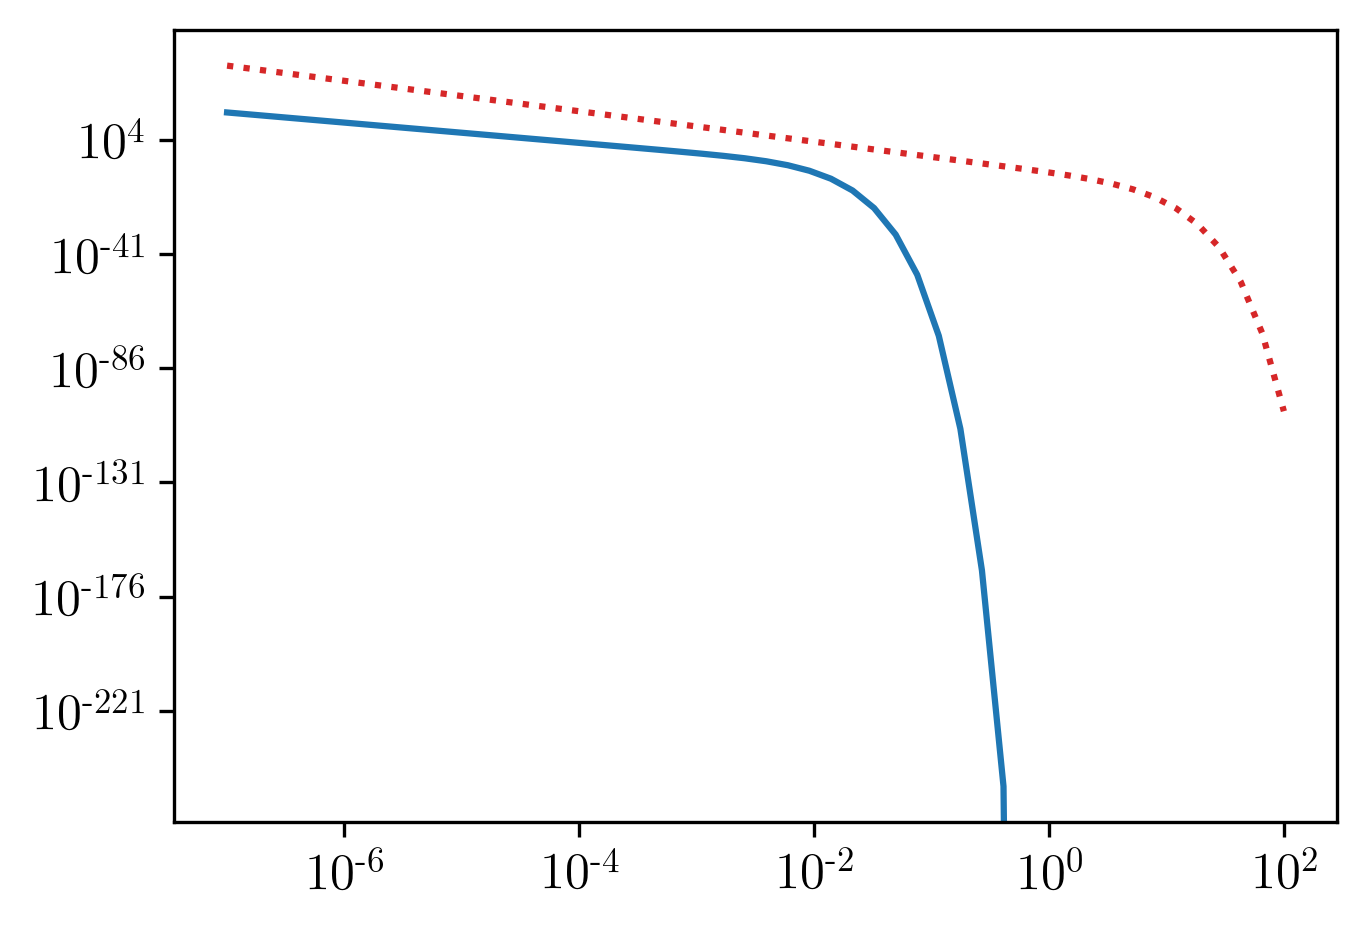

In [74]:
plt.loglog(
    xs, svs_xx_to_sms * n_eq_xs**2, ":", color=mpl_colors[3],
#     label=r"$\langle \sigma v \rangle_{\bar{\chi}\chi \to \mathrm{SM}} \, n_\chi^\mathrm{eq}$"
)
plt.loglog(xs, np.array([
    hp.thermal_cross_section_ff_to_xx(hp.ms / temp, 173e3) * n_eq(temp, 173e3, 2 * 3 * 2, "fermion")**2
    for temp in temps
]))

#### Scratch

Text(0, 0.5, '$\\langle \\sigma v \\rangle_{\\bar{\\chi}\\chi,0} / (g_{S\\chi} \\sin\\theta)^2$ [cm$^3$/s]')

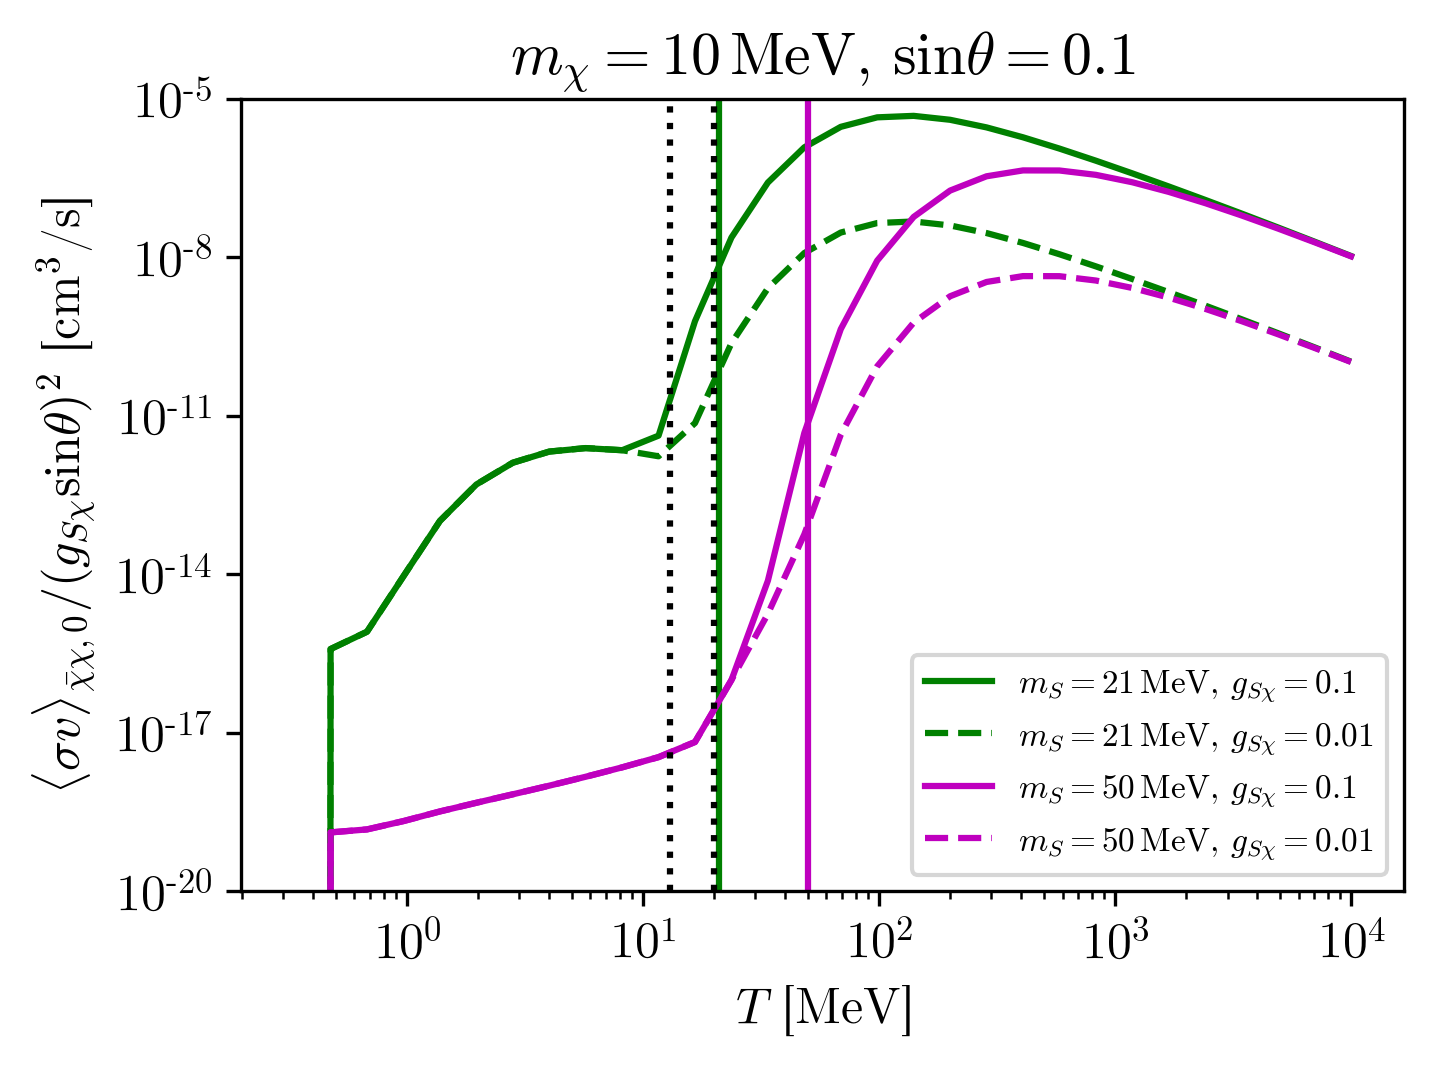

In [1393]:
xs = np.geomspace(0.01, 300, 30)
mx = 10

svs = []
svs_alt = []
ms = 2.1 * mx
for x in xs:
    hp = HiggsPortal(mx, ms, gsxx=0.1, stheta=0.1)
    svs.append(hp.thermal_cross_section(x) / hp.gsxx**2 / hp.stheta**2)
    
    hp_alt = HiggsPortal(mx, ms, gsxx=0.01, stheta=0.1)
    svs_alt.append(hp_alt.thermal_cross_section(x) / hp_alt.gsxx**2 / hp_alt.stheta**2)

plt.loglog(100 / xs, svs, "g", label=r"$m_S = %i \, \mathrm{MeV}$, $g_{S\chi} = 0.1$" % ms)
plt.loglog(100 / xs, svs_alt, "g--", label=r"$m_S = %i \, \mathrm{MeV}$, $g_{S\chi} = 0.01$" % ms)
plt.axvline(ms, color="g")

svs = []
svs_alt = []
ms = 5 * mx
for x in xs:
    hp = HiggsPortal(mx, ms, gsxx=0.1, stheta=0.1)
    svs.append(hp.thermal_cross_section(x) / hp.gsxx**2 / hp.stheta**2)
    
    hp_alt = HiggsPortal(mx, ms, gsxx=0.01, stheta=0.1)
    svs_alt.append(hp_alt.thermal_cross_section(x) / hp_alt.gsxx**2 / hp_alt.stheta**2)

plt.loglog(100 / xs, svs, "m", label=r"$m_S = %i\, \mathrm{MeV}$, $g_{S\chi} = 0.1$" % ms)
plt.loglog(100 / xs, svs_alt, "m--", label=r"$m_S = %i\, \mathrm{MeV}$, $g_{S\chi} = 0.01$" % ms)
plt.axvline(ms, color="m")

# plt.axvline(0.5, color="r")
# plt.axvline(105, color="r")
plt.axvline(13, color="k", linestyle=":")
plt.axvline(20, color="k", linestyle=":")

plt.title(r"$m_\chi = %g \, \mathrm{MeV}$, $\sin\theta = 0.1$" % mx)
plt.legend(fontsize=8)
plt.ylim(1e-20, 1e-5)
plt.xlabel(r"$T$ [MeV]")
plt.ylabel(r"$\langle \sigma v \rangle_{\bar{\chi}\chi,0} / (g_{S\chi} \sin\theta)^2$ [cm$^3$/s]")

In [1084]:
hp = HiggsPortal(mx=0.1, ms=0.21000000000000002, gsxx=0.37387522703120396, stheta=0.01)
hp.annihilation_cross_sections(2 * hp.mx * (1 + 1/2 * 1e-3**2))
hp.thermal_cross_section(2)

2.1143754965064496e-11

In [1442]:
v_mw = 0.001

def get_hp_relic(mx, ms, stheta, semi_analytic=True):
    """
    Get relic abundance for Higgs portal model where the DM annihilates
    into mediators.
    """
    def fn(log_gsxx):
        hp = HiggsPortal(mx, ms, 10**log_gsxx, stheta)
        hp.gsxx = 10**log_gsxx
        return relic_density(hp, semi_analytic) - Omega_dm

    if ms < mx:
        bracket = [-5, np.log10(4 * np.pi)]
    else:
        bracket = [-10, 10]
        
    print([fn(b) for b in bracket])
    
    sol = root_scalar(fn, bracket=bracket, xtol=1e-100, rtol=1e-4)
    if not sol.converged:
        raise Exception("didn't converge")

    gsxx_relic = 10**sol.root
    hp = HiggsPortal(mx, ms, gsxx_relic, stheta)
    sigma = hp.annihilation_cross_sections(
        2 * hp.mx * (1 + 1/2 * v_mw**2)
    )["total"]
    sv = sigma * v_mw * sv_inv_MeV_to_cm3_per_s
    b = sigma / v_mw
#     print()

    return sv, gsxx_relic, b

In [1415]:
semi_analytic = True
stheta = 1e-1

mxs_sm = np.geomspace(1e-1, 250, 40)
mss_sm = 3.1 * mxs_sm
svs_sm = np.full_like(mxs_sm, np.inf)
gsxxs_sm = np.full_like(mxs_sm, np.inf)
bs_sm = np.full_like(mxs_sm, np.inf)
for i in range(len(svs_sm)):
    svs_sm[i], gsxxs_sm[i], bs_sm[i] = get_hp_relic(
        mxs_sm[i], mss_sm[i], stheta, semi_analytic
    )
#     try:
#         svs_sm[i], gsxxs_sm[i], bs_sm[i] = get_hp_relic(
#             mxs_sm[i], mss_sm[i], stheta, semi_analytic
#         )
#     except ValueError:
#         print("error")
#         break
# #     break
print()

mxs_ss = np.geomspace(1e-1, 1e3, 15)
mss_ss = 0.5 * mxs_ss
svs_ss = np.zeros_like(mxs_ss)
gsxxs_ss = np.zeros_like(mxs_ss)
bs_ss = np.full_like(mxs_ss, np.inf)
for i in range(len(svs_ss)):
    svs_ss[i], gsxxs_ss[i], bs_ss[i] = get_hp_relic(
        mxs_ss[i], mss_ss[i], stheta, semi_analytic
    )

[2148.338957684425, -0.21999862997351954]
[2413.124647606395, -0.2199982653820249]
[2661.675179301045, -0.21999780377081066]
[2878.2196682893355, -0.21999721932386893]
[3052.3916384706868, -0.2199964793561935]
[3195.533847015128, -0.21999554248621556]
[3525.860479621679, -0.2199943563220265]
[4309.158728090479, -0.21999285453204143]
[5265.229547257512, -0.21999095313634898]
[6432.715809128201, -0.21998854581061814]
[7857.859096790884, -0.2199854980884095]
[9596.662942309616, -0.21998164186396957]
[11716.824340165387, -0.21997677507435534]
[14300.27280366659, -0.21997074934972494]
[17446.75738558601, -0.2199635588044449]
[21273.522536147106, -0.21995561623980237]
[25918.869719004433, -0.21994771447286277]
[31545.621279485847, -0.2199406786172861]
[38342.602905818254, -0.21993456627054384]
[46524.511499700304, -0.21992800793055028]
[56328.953259794514, -0.21991894952244298]
[68005.53753896548, -0.21990577197480524]
[81798.09690657968, -0.2198875971316891]
[97918.3466671343, -0.2198633504

/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/scalar_mediator/_scalar_mediator_cross_sections.py:445: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return tcs(
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/scalar_mediator/_scalar_mediator_cross_sections.py:445: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return tcs(


[161326.75882788777, -0.21973877386761836]
[187635.17620616517, -0.21967207465587396]
[217060.92298061767, -0.2195870858302489]
[250560.5104780053, -0.21947927324097502]
[289776.9305818863, -0.21934266522570336]
[336808.75679706124, -0.21916927920458473]
[392502.2157710278, -0.21894923711511458]
[455273.7239413441, -0.21867058315439258]
[523112.6016646706, -0.218318129328587]
[594108.4620554149, -0.2178719800770637]
[664586.3077336182, -0.21730679147450893]
[726888.3417640419, -0.21659030458756978]
[769051.4866606457, -0.21568356392671226]


/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/scalar_mediator/_scalar_mediator_cross_sections.py:445: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return tcs(


[780320.8707505576, -0.214542940026267]


/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/scalar_mediator/_scalar_mediator_cross_sections.py:445: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return tcs(



[1874.5580570563793, -0.21999999999999972]
[2805.830710033835, -0.21999999999999906]
[3748.6811303389213, -0.21999999999999686]
[7392.180735013154, -0.21999999999998962]
[14423.258291181386, -0.21999999999996578]
[27821.32700861121, -0.2199999999998889]
[52782.24830515235, -0.21999999999970268]
[97005.18385085625, -0.219999999999257]
[167157.4827170476, -0.21999999999763192]
[269770.84950979694, -0.21999999999221467]
[441375.91143565235, -0.21999999997435654]
[668091.8632556999, -0.21999999991544558]
[775004.9555707745, -0.21999999972140602]
[763318.7641221046, -0.21999999908833134]
[1320373.8552963661, -0.2199999972707686]


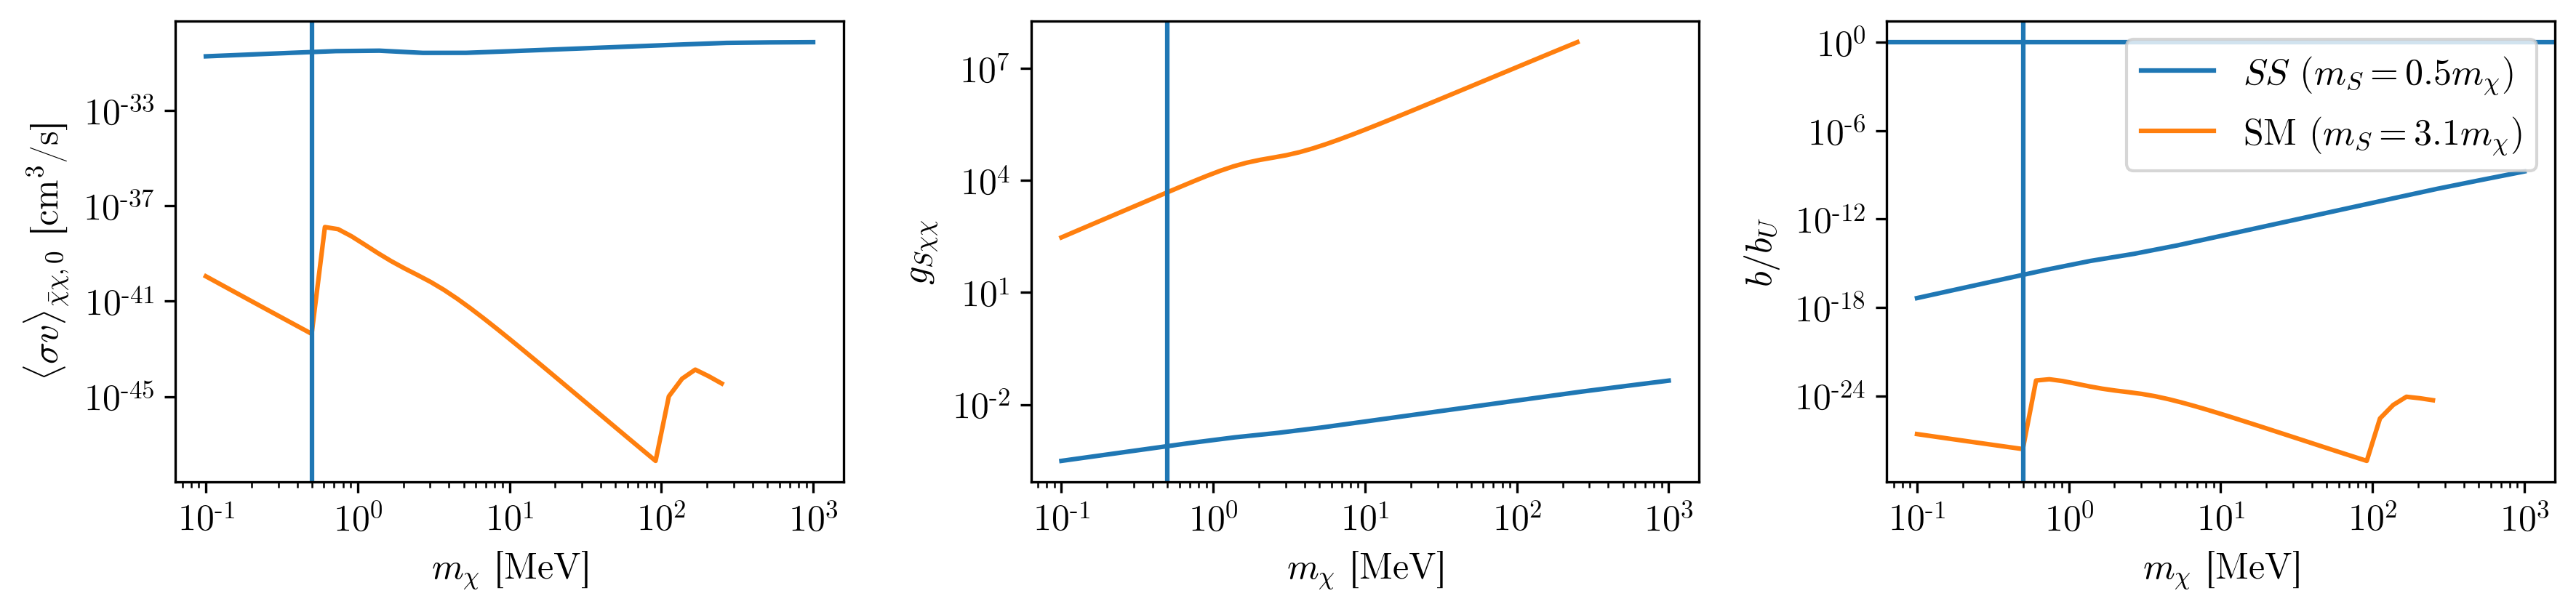

In [1416]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.loglog(mxs_ss, svs_ss, # / (gsxxs_ss)**4,
)
plt.loglog(mxs_sm, svs_sm, # / (gsxxs_sm * stheta)**2,
)
plt.axvline(0.5)
# plt.ylim(1e-50, 1e-30)
# plt.ylim(1e-40, 1e-16)
plt.xlabel(r"$m_\chi$ [MeV]")
plt.ylabel(r"$\langle \sigma v \rangle_{\bar{\chi}\chi,0}$ [cm$^3$/s]")

plt.subplot(1, 3, 2)
plt.loglog(mxs_ss, gsxxs_ss)
plt.loglog(mxs_sm, gsxxs_sm)
plt.axvline(0.5)
# plt.ylim(1e-4, 1e8)
plt.xlabel(r"$m_\chi$ [MeV]")
plt.ylabel(r"$g_{S\chi\chi}$")

plt.subplot(1, 3, 3)
plt.loglog(
    mxs_ss, bs_ss / (12 * pi / mxs_ss**2),
    label=r"$S S$ ($m_S = %g m_\chi$)" % (mss_ss[0] / mxs_ss[0])
)
plt.loglog(mxs_sm, bs_sm / (12 * pi / mxs_sm**2),
    label=r"SM ($m_S = %g m_\chi$)" % (mss_sm[0] / mxs_sm[0])
)
plt.axhline(1)
plt.axvline(0.5)
# plt.ylim(1e-35, 1e1)
plt.xlabel(r"$m_\chi$ [MeV]")
plt.ylabel(r"$b / b_U$")
plt.legend()

plt.tight_layout()

Text(0.5, 1.0, '$\\sin\\theta = 0.1$')

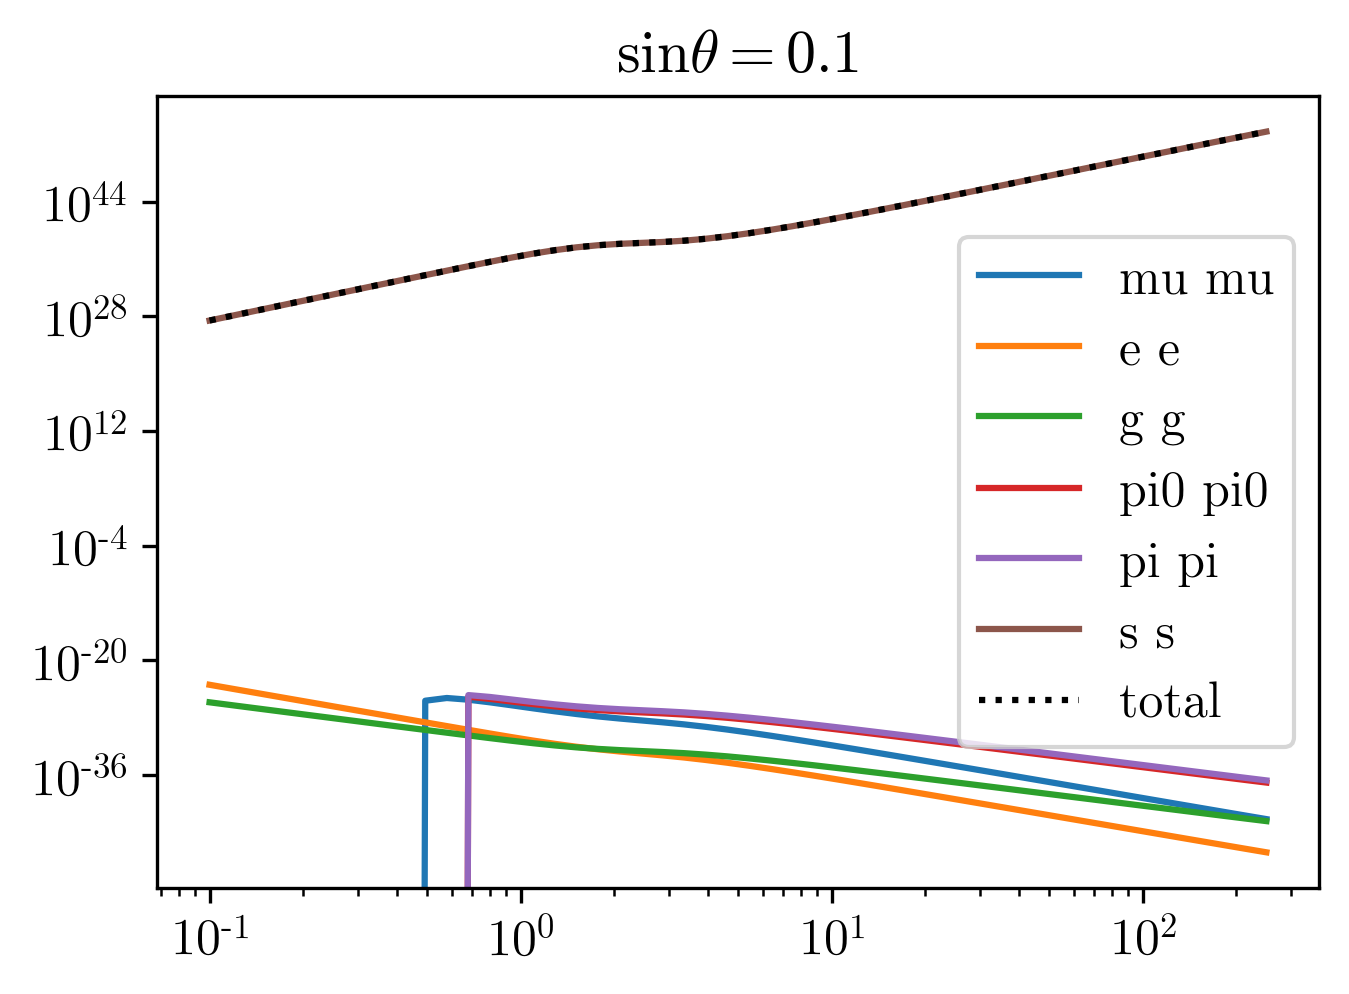

In [1383]:
hp = HiggsPortal(1, 1, gsxx=1, stheta=1e-1)
sigmas_sm = {
    fs: np.zeros_like(mxs_sm) for fs in hp.list_annihilation_final_states() + ["total"]\
}
v_x = 0.99999
for i, (mx, ms) in enumerate(zip(mxs_sm, mss_sm)):
    hp.mx = mx
    hp.ms = ms
    hp.gsxx = gsxxs_sm[i]
    for fs, sigma in hp.annihilation_cross_sections(
        2 * mx * 1 / np.sqrt(1 - v_x**2)
    ).items():
        sigmas_sm[fs][i] = sigma

for fs, sigmas in sigmas_sm.items():
    if fs == "total":
        plt.loglog(mxs_sm, sigmas, ":k", label=fs)
    else:
        plt.loglog(mxs_sm, sigmas, label=fs)

# plt.ylim(1e-33, 1e-13)
plt.legend()
plt.title(r"$\sin\theta = %g$" % hp.stheta)

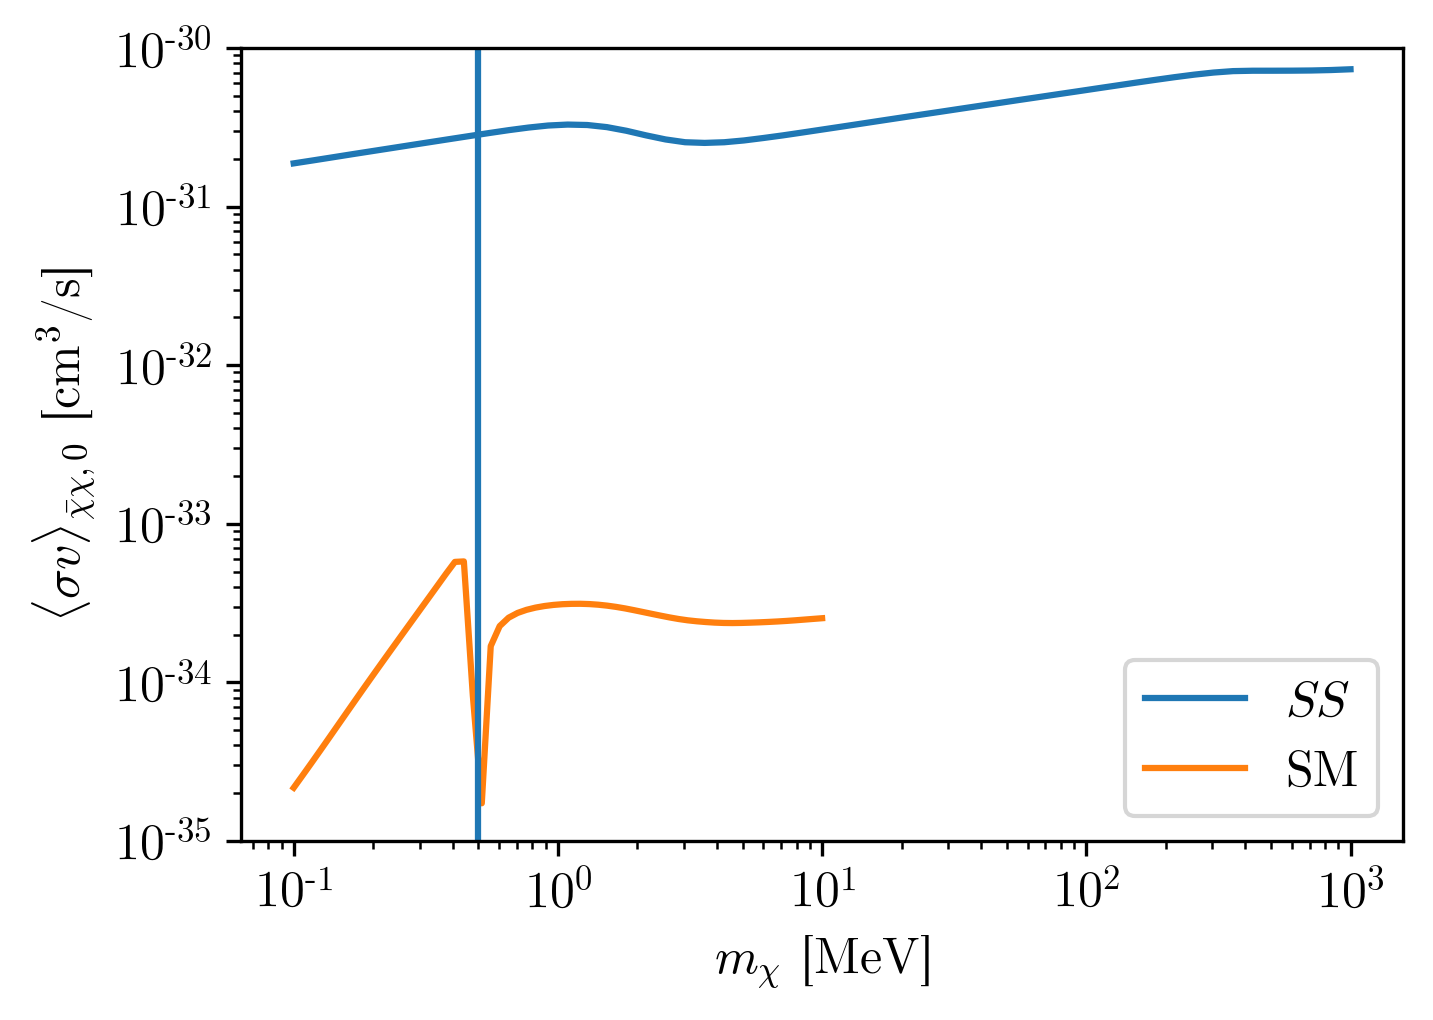

In [966]:
plt.loglog(mxs_ss, svs_ss, label=r"$S S$")
plt.loglog(mxs_sm, svs_sm, label="SM")
plt.axvline(0.5)
plt.xlabel(r"$m_\chi$ [MeV]")
plt.ylabel(r"$\langle \sigma v \rangle_{\bar{\chi}\chi,0}$ [cm$^3$/s]")
plt.ylim(1e-35, 1e-30)
plt.legend()

### Checking constraints on $\sin\theta$

In [10]:
def get_constr_label(name):
    """
    Labels for pheno constraints.
    """
    name = f"${name}$"
    label = name.replace("->", "\\to")
    label = label.replace("e e", "e^+ e^-")
    label = label.replace("mu mu", "\mu^+ \mu^-")
    label = label.replace(" pi0", " \pi^0")
    label = label.replace(" pi", " \pi")
    label = label.replace("k ", "K ")
    label = label.replace("kl ", "K_L ")
    label = label.replace("higgs ", "h ")
    label = label.replace(" invis", "\, \mathrm{invis.}")
    label = label.replace("charm", "\mathrm{CHARM}")
    return label

In [209]:
hp = HiggsPortal(mx=100, ms=1, gsxx=1, stheta=1.)
ms_over_mx = 1.1
if ms_over_mx < 1:  # xx->ss
    mx_grid = np.linspace(0.1, 1000, 60)
else:  # xx->SM
    mx_grid = np.linspace(0.1, 500, 60)
ms_grid = ms_over_mx * mx_grid
stheta_grid = np.geomspace(1e-6, 0.999, 50)
# constrs = hp.constrain("ms", ms_grid, "stheta", stheta_grid, "image")

# > 0: allowed, < 0: not allowed.
constrs = {
    c: np.full([len(stheta_grid), len(mx_grid)], np.inf) for c in hp.constraints()
}
for i in range(len(stheta_grid)):  # stheta
    for j in range(len(mx_grid)):  # mx, ms
        hp.mx = mx_grid[j]
        hp.ms = ms_grid[j]
        hp.stheta = stheta_grid[i]
        for c, fn in hp.constraints().items():
            constrs[c][i, j] = fn()

<ipython-input-210-e3298e70581a>:4: UserWarning: linewidths is ignored by contourf
  plt.contourf(


Text(0.5, 1.0, '$m_S = 1.1 m_\\chi,\\, g_{S\\chi} = 1$')

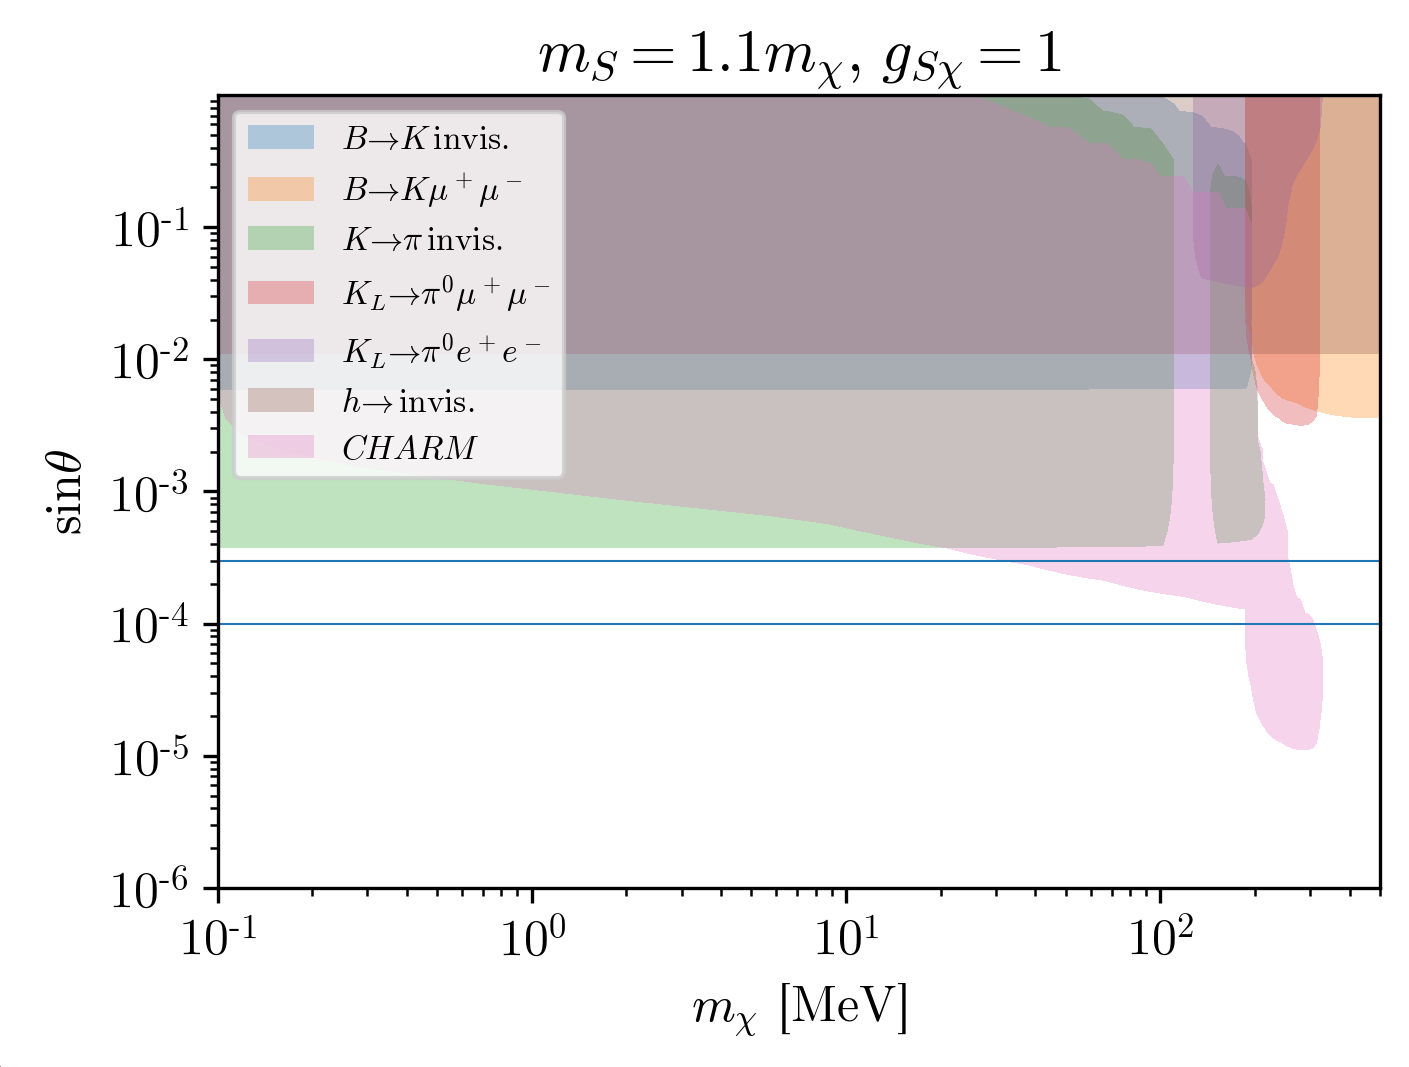

In [210]:
for (name, constr), color in zip(constrs.items(), mpl_colors):
#     if name == "higgs -> invis":
#         continue
    plt.contourf(
        mx_grid, stheta_grid, constr, levels=[-1e100, 0], colors=[color],
        linewidths=[1], alpha=0.3
    )
    proxy = plt.Rectangle(
        (0, 0), 1, 1, fc=color, label=get_constr_label(name), alpha=0.3
    )
    plt.gca().patches += [proxy]

plt.fill_between(mx_grid[[0, -1]], 1, 1e10, color="k", alpha=0.5)
plt.axhline(3e-4, linewidth=0.5)
plt.axhline(1e-4, linewidth=0.5)

plt.xlim(mx_grid[[0, -1]])
plt.ylim(stheta_grid[[0, -1]])
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$m_\chi$ [MeV]")
plt.ylabel(r"$\sin \theta$")
plt.legend(fontsize=8, loc="upper left")
plt.title(r"$m_S = %g m_\chi,\, g_{S\chi} = %g$" % (ms_over_mx, hp.gsxx))

## Vector
Need to sort out pheno constraints.

In [32]:
mvs = [200, 1000]

vm_args = np.array([
    [{"mx": 1., "mv": mv, "gvxx": 1., "eps": 0.1} for mv in mvs],
    [{"mx": 1., "mv": mv, "gvxx": 1., "gvuu": 1, "gvdd": -1, "gvss": 0.} for mv in mvs],
    [{"mx": 1., "mv": mv, "gvxx": 1., "gvuu": 1, "gvdd": 1, "gvss": 0.} for mv in mvs]
])

VMs = np.array([
    [KineticMixing, KineticMixing],
    [QuarksOnly, QuarksOnly],
    [QuarksOnly, QuarksOnly]
])

# Instantiate all the models
vms = np.vectorize(lambda VM, args: VM(**args))(VMs, vm_args)

In [33]:
# Recompute constraints
sv_constraints_vms = np.empty_like(vms)
for i in range(len(vms)):
    for j in range(len(vms[i])):
        sv_constraints_vms[i, j] = get_sv_constraints(vms[i, j], mxs)

# Save results
np.savez(
    "data/sv_constraints_vms.npz", sv_constraints_vms=sv_constraints_vms, vm_args=vm_args
)

# # Load precomputed constraints
# sv_constraints_vms = np.load(
#     "data/sv_constraints_vms.npz", allow_pickle=True
# )["sv_constraints_vms"]

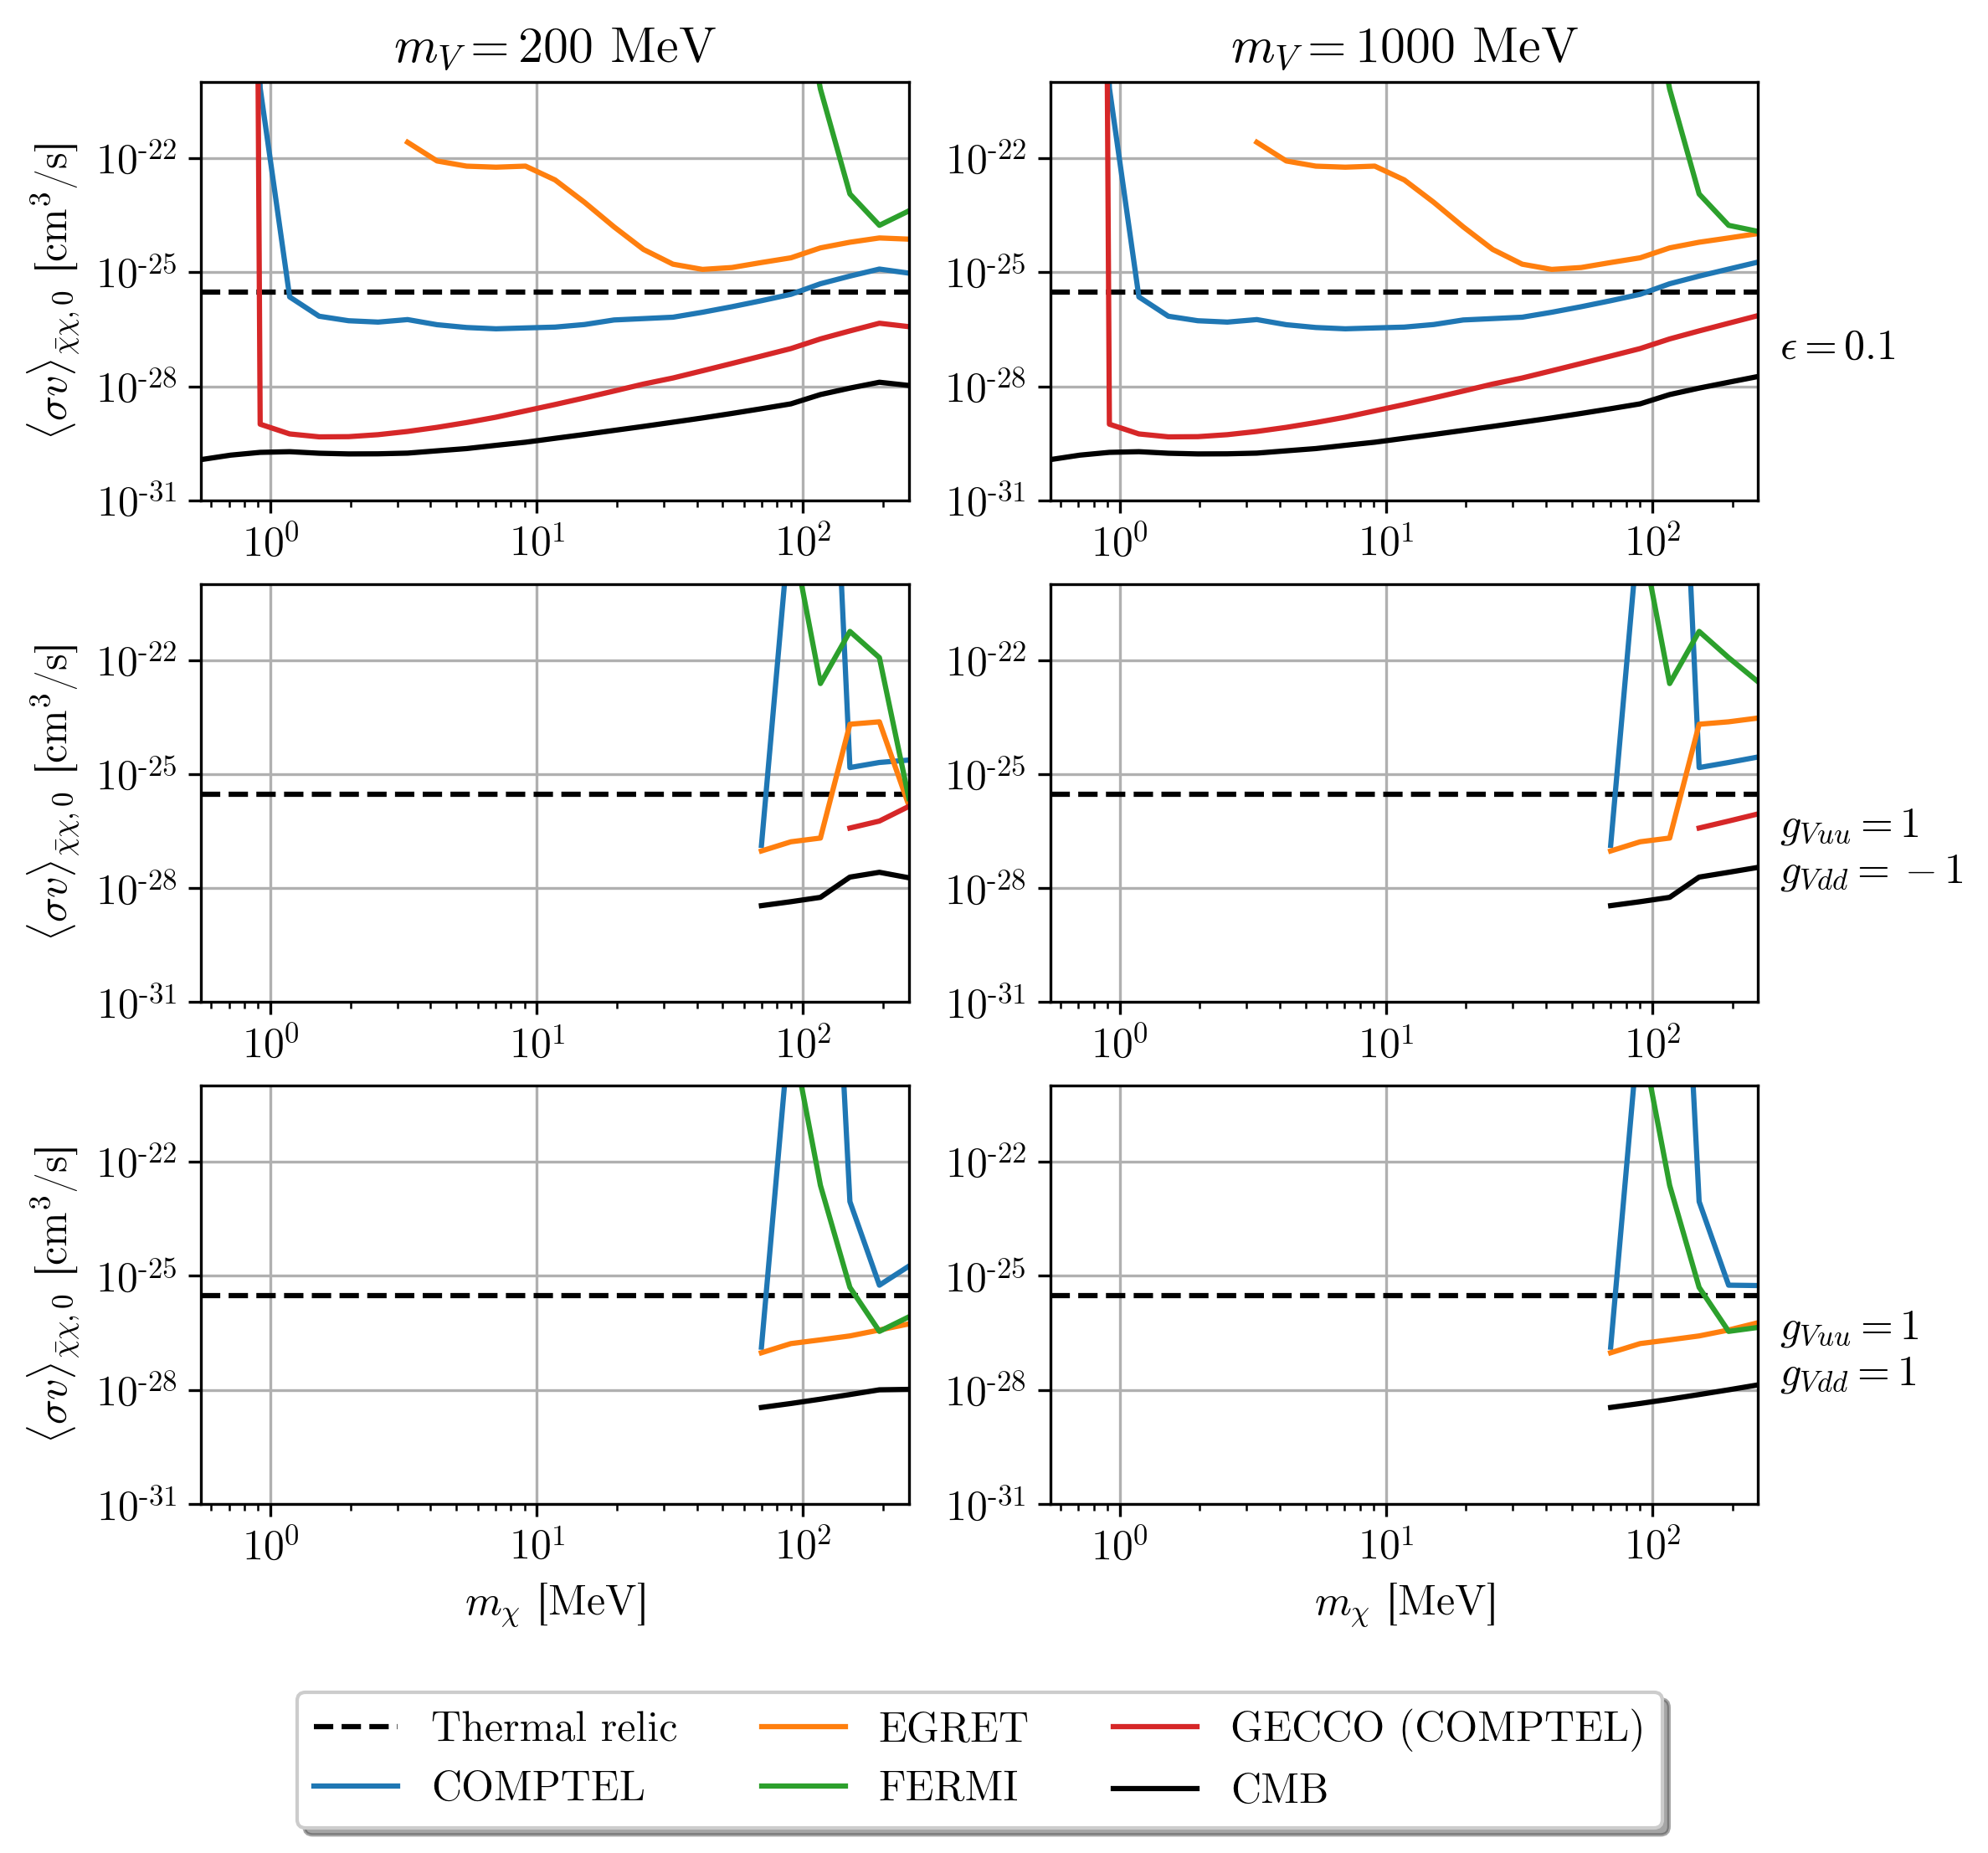

In [36]:
fig, axes = get_formatted_fig(
    *vms.shape, (4 * vms.shape[1], 2.5 * vms.shape[0]),
    mxs[[0, -1]], (1e-31, 1e-20)
)

# Current constraints
for i in range(len(axes)):
    for j in range(len(axes[i])):
        ax = axes[i, j]
        
        # Thermal relic cross section
        ax.axhline(3e-26, linestyle="--", color="k", label="Thermal relic")
        
        # Constraints
        for key, svs in sv_constraints_vms[i, j].items():
            if key in ["comptel_check", "gecco_large", "e_astrogam", 'gecco_gc', 'gecco_egret', 'gecco_fermi', 'gecco_draco']:
                continue
            elif key == "cmb":
                ax.plot(mxs, svs, "k", label=r"CMB")
            else:
                ax.plot(mxs, svs, label=get_constraint_label(key))

# Mediator mass labels
for mv, ax in zip(mvs, axes[0]):
    ax.set_title(r"$m_V = $" + f"{mv} MeV")

# Coupling labels
row_labels = [
    r"$\epsilon = %.1f$" % vms[0, -1].eps,
    r"$g_{Vuu} = %i$" % vms[1, -1].gvuu + "\n" + "$g_{Vdd} = %i$" % vms[1, -1].gvdd,
    r"$g_{Vuu} = %i$" % vms[2, -1].gvuu + "\n" + "$g_{Vdd} = %i$" % vms[2, -1].gvdd,
]
for label, ax in zip(row_labels, axes[:, -1]):
    ax.text(3e2, 1e-27, label, va="center")

# Put a legend below last axis
axes[-1, -1].legend(
    loc='upper center', bbox_to_anchor=(-0.1, -0.4), fancybox=True, shadow=True, ncol=3
)

fig.savefig("figures/gecco/vm_comptel.png", bbox_inches="tight")

In [38]:
T_obs_nt / 1e6

1.0

In [24]:
beeper.beep(frequency=900, secs=0.7, blocking=True)